In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation

Heart Failure Prediction Dataset from Kaggle

https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

One thing to not is that the Kaggle dataset specifies the Cholesterol unit of measurement as mm/dl, which doesn't exist. The assumption is that it is a measurement of the triglycerides in mg/dl

In [2]:
df = pd.read_csv("heart.csv")
col = df.pop("HeartDisease")
df.insert(0, col.name, col)#Put class label in front
dataset = df.copy()
dataset

,HeartDisease,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,0,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,1,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,0,54,M,NAP,150,195,0,Normal,122,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,45,M,TA,110,264,0,Normal,132,N,1.2,Flat
914,1,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat
915,1,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat
916,1,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat


## Exploratory Data Analysis

In [3]:
#Preliminary look at data

#!pip install ydata-profiling
#!pip install summarytools
from summarytools import dfSummary
from ydata_profiling import ProfileReport, compare

report = ProfileReport(df=dataset, title="Heart disease data profile")
report.to_file("profile_report.html")
dfSummary(dataset)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,HeartDisease[int64],Mean (sd) : 0.6 (0.5)min < med < max:0.0 < 1.0 < 1.0IQR (CV) : 1.0 (1.1),2 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAW5JREFUeJzt2kFqwkAAhtFMCWI3EQl4GA/Rw/YQuY1IsqiloCk5gDSGiP3hvW1mhll8DBmYMo5jBf/d26s3AHPUs0bBDKWU96qqNtUyP+M4Xu59FCqrRdq27UfTNPsl84dhOJdSPu/FKlTWspkiPR6Pl91u9/3IxL7vt13X7U+n03QaC5XnmyI9HA5fC6ZOvw13uUwRQahEECoRhEoEoRJBqEQQKhGESgShEqF+5UMDWCXUZz80gLVO1Kc+NIC56lc+NIC5XKaIIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQi1HMG9X2/fXThac71ep3Wb0opizZHlOZ2u9VLW/lr0C/U0k59/xn6AQAAAABJRU5ErkJggg=="">",0(0.0%)
2,Age[int64],Mean (sd) : 53.5 (9.4)min < med < max:28.0 < 54.0 < 77.0IQR (CV) : 13.0 (5.7),50 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAoBJREFUeJzt3U9u2kAYh+GZmkQulowQEuy4QKUuWHKIHLZH6IITcAN2SMgC4cayMY6cVZtF479hfvb7rDMJizcWtsefbVEUBnDdt0d/AKCKSaWfQi3W2u/GmOeGy9OiKF47/kjyCLWHSBeLxUsYhvMm6y+XS2St/UWs/yLU7j2XkW6329fZbJbUWXg+n/3dbjc/nU7l0ZhQ/0KoPSkjXS6XfxosLb824ANOpiCBUCGBUCGBUCGBUCGBs37H5Hn+ZIwJrbVNf0U6xGuwhOqQOI6fsiz7uV6vPc/zal2DHfoNA0J1SJqmE9/3p5vNJlmtVlHd9ecB3zAgVAcFQdD0ZsFgbxhwMgUJhAoJhAoJhAoJhAoJnPV3v0s/vN/v5UV7dIhQO96ln2WZn+f5jyRJfhtjml5iwgeE2vEu/cPhMN/v99Pb7eb19/HGh1A73qUfRdEgL7g/GidTkECokECokECokECokECokECokECokECokECokECokDDYe/0th+myVc8xgwy17TBd5a16ebsBFs4OrxhkqG226Slv1YtbDrBweXjFUENtNUxXdate2mKAhevDKwYd6lgFzQdYOPsP6nSoPLcE50PluSVIhMpzS1AJ9R3PLaHEnSlIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIcH5TCr6Oyy8M7jVUngTVETv+wuDeQh3zk6CKUsdfGNznEXWUT4KqCxx9YXDv31HH9iQo+sFZPyQQKiQQKiRwHRUSc68+DZUhEHBh7tV/Q2UIBFyZe/XZEZUhEHBi7lWl76gMgcCjTaoemuv+4uv1+r4mjmP/eDxOv3K96t9W/dym5foqfb0B/rCy6fPoo6UAAAAASUVORK5CYII="">",0(0.0%)
3,Sex[object],1. M2. F,725 (79.0%)193 (21.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAS9JREFUeJzt20GKwkAQheFqCaKbhBDIYXIID+shcpsgyULFTUsdIq8a6v8Ws7Uh/6gz9Cu1VgMUipndzewqeTVE+tVaP5EH6KZpevR9P0YeAuc7juNVSnlGBtd5aMuyfIZh+EYdAufa9/22ruu4bZt/gsXF5j88tHme31GHgIR/XQp1iT4A8iA2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUF7n80v1+leEmqtPN/Orwv7Lc4WLtfhPP6cfYdggRi85PGLHrwUpnzI9s4W/luHJFO+FmZmSDDla2VmhjxTPv4SToB/6kKG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsSGPFO+VmZmSDLla2FmhvMxeIGp/AEKW2rfpJtyjgAAAABJRU5ErkJggg=="">",0(0.0%)
4,ChestPainType[object],1. ASY2. NAP3. ATA4. TA,496 (54.0%)203 (22.1%)173 (18.8%)46 (5.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAdtJREFUeJzt20FqwkAAheFJCaXdKCJ4GA/Rw/YQ3kaKLmrpJmW21hZa5CXMfN+iGxcR+YmNzBumaSqQ8BC5CoiNpKGU8lxKeYxetW2f0zRd5n4TSzRut9uX1Wq1mfuNtOJ8Pr8Nw/AquO/GGtp+v7+s1+uPG6/zB6fT6elwOGyOx2P9phDblbH+qaHtdrv36xf5l/pvCTd4QCBGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2sqc+6tGY3CXb5XP83VgP+9UzWI7G3Ef9POtp3bnfxxI5Fn5/joX/YDDlI8UDAl1+jfr6adxi1lVWSe1bxLrKKqkPS1pX+emlcR4QiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsdHXlG/u69PZlM8Ern02CMSY8tH8nc1drEOzrKssqfoUX1dZUvVrrnWVJVWH/KhLjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjXbXVZZU/ZplXWVJ1ScbBGKsq1jUnc1diMy6yhKKyLrKEor0usoSirvwoy4xYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2lrGusoQiuq6yhOJebBCIsa4ixgMCJeULs1jYuUMXmyYAAAAASUVORK5CYII="">",0(0.0%)
5,RestingBP[int64],Mean (sd) : 132.4 (18.5)min < med < max:0.0 < 130.0 < 200.0IQR (CV) : 20.0 (7.2),67 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AA

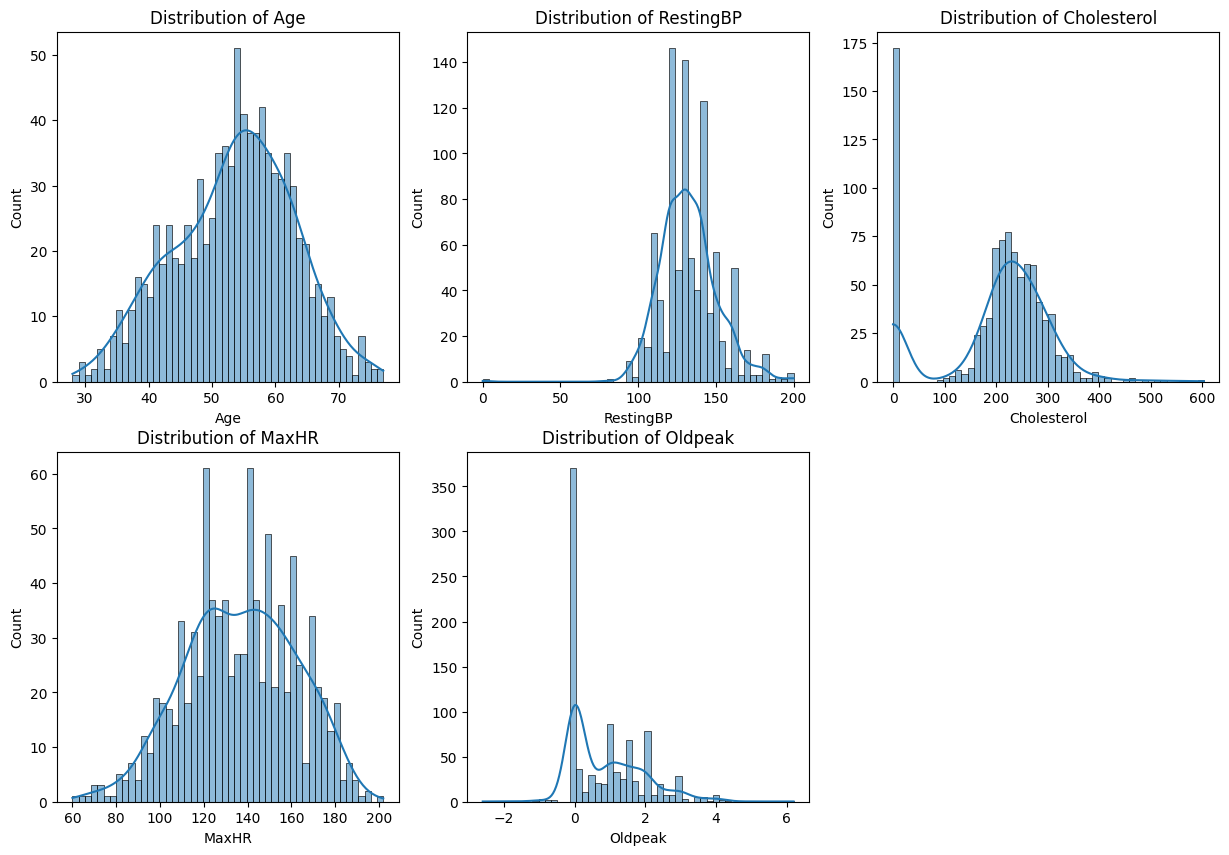

In [4]:
plt.figure(figsize=(15, 10))


numerical_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(dataset[col], kde=True, bins=50)
    plt.title("Distribution of {}".format(col))

plt.show()

### Description Of Data

<ol>
    <li>"Heart Disease": Class Label</li>
    <li>"Age": Only whole numbers so can be discretised into age groups. Would be useful to bin according to susceptible age groups for heart disease</li>
    <li>"Sex": Should be transformed into binary values</li>
    <li>"ChestPainType" (4 Ordinal Values):
        <ol>
            <li>(TA): Typical Angina (Most Characteristic of Heart Disease)</li>
            <li>(ATA): Atypical Angina</li>
            <li>(NAP): Non-Anginal Chest Pain</li>
            <li>(ASY): Asymptomatic (Least Characteristic of Heart Disease)</li>
        </ol>
    </li>
    <li>"RestingBP": Blood Pressure measure at rest. No Discretisation necessary for Random Forest</li>
    <li>"Cholestrol": No Discretisation necessary for Random Forest</li>
    <li>"FastingBS": Fasting Blood Sugar. Binary values</li>
    <li>"RestingECG": Resting electrocardiogram (3 (arguably nominal) values):
        <ol>
            <li>(Normal): Typical Angina (Most Characteristic of Heart Disease)</li>
            <li>(ST): ST-T wave abnomality</li>
            <li>(LVH): Left Ventricular Hypertrophy</li>
        </ol> There is not a strict progression of severity
    </li>
    <li>"MaxHR": Maximum Heart Rate achieved (during exercise). Numeric value between 60 and 202</li>
    <li>"ExerciseAngina": Exercise-induced Angina. Binary Values</li>
    <li>"OldPeak": ST depression in the ST segment of an ECG. My interpretation of this attribute is that the range is: $0 \leq$ Oldpeak. As Oldpeak referes to ST <i>depression</i> and not elevation. Negative values can be considered measurement error or human recording error</li>
    <li>"ST_Slope": Slope of the peak exercise ST segment (3 Ordinal Values):
        <ol>
            <li>(Up): Upsloping</li>
            <li>(Flat)</li>
            <li>(Down): Downsloping</li>
        </ol>
    </li>
</ol>

### Check Data Types

In [5]:
dataset.dtypes

HeartDisease        int64
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
dtype: object

### Check For Missing Values, Duplicated Values

In [6]:
dataset.isnull().sum()

HeartDisease      0
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
dtype: int64

In [7]:
print(dataset.duplicated().sum())

0


### Encoding of Categorical Variables

Encoding must be done before imputation so this is done early on

In [8]:
from sklearn.preprocessing import OrdinalEncoder

#Dummy Encoding for attributes with binary categories
dataset = pd.get_dummies(dataset, columns=["Sex", "ExerciseAngina"], drop_first=True, dtype=int)


#One-hot Encoding for attributes with 3 or more categories
dataset = pd.get_dummies(dataset, columns=["RestingECG"], drop_first=False, dtype=int)


#Ordinal Encoding for ordinal attributes
categories = [
    ["Down", "Flat", "Up"],#ST_Slope
    ["ASY", "NAP", "ATA", "TA"]#ChestPainType
]

encoder = OrdinalEncoder(categories=categories)
dataset[["ST_Slope", "ChestPainType"]] = encoder.fit_transform(dataset[["ST_Slope", "ChestPainType"]])


dataset

,HeartDisease,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ST_Slope,Sex_M,ExerciseAngina_Y,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,0,40,2.0,140,289,0,172,0.0,2.0,1,0,0,1,0
1,1,49,1.0,160,180,0,156,1.0,1.0,0,0,0,1,0
2,0,37,2.0,130,283,0,98,0.0,2.0,1,0,0,0,1
3,1,48,0.0,138,214,0,108,1.5,1.0,0,1,0,1,0
4,0,54,1.0,150,195,0,122,0.0,2.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,45,3.0,110,264,0,132,1.2,1.0,1,0,0,1,0
914,1,68,0.0,144,193,1,141,3.4,1.0,1,0,0,1,0
915,1,57,0.0,130,131,0,115,1.2,1.0,1,1,0,1,0
916,1,57,2.0,130,236,0,174,0.0,1.0,0,0,1,0,0


### Check for Unrealistic values

RestingBP and Cholestrol have values of 0 which humans can't have

Oldpeak also seems to have an unrealistic number of values at 0 and it also has negative values. Small negative values can be interpreted as measurement error and be set 0

In [9]:
display(dataset.describe().T)

,count,mean,std,min,25%,50%,75%,max
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
ChestPainType,918.0,0.748366,0.931031,0.0,0.00,0.0,1.0,3.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
ST_Slope,918.0,1.361656,0.607056,0.0,1.00,1.0,2.0,2.0
Sex_M,918.0,0.789760,0.407701,0.0,1.00,1.0,1.0,1.0


#### Imputation

Unrealistic Values for Cholesterol and RestingBP turned into np.nan so variance before and after imputation can be calculated

Experimented with different imputation techniques to find one that left the variance relatively the same after imputation

I tested three:

<ul>
    <li>Linear Regression Imputation</li>
    <li>KNN Imputation</li>
    <li>Stochastic Quantile Imputation</li>
</ul>

Linear Regression Imputation imputed values heavily around the mean

KNN Imputation seemed to have a similar effect in terms of variance after imputation

Stochastic Quantile Imputation had the least variance but doesn't seem to be a very popular method as it is a heuristic approach and may well be degrading the dataset instead.

In [10]:
#Turn 0 values into missing values
dataset.loc[dataset["Cholesterol"] == 0, "Cholesterol"] = np.nan
dataset.loc[dataset["RestingBP"] == 0, "RestingBP"] = np.nan

display(dataset.isnull().sum())

print("Number of Oldpeak Values < 0: {}".format((dataset["Oldpeak"] < 0).sum()))

HeartDisease           0
Age                    0
ChestPainType          0
RestingBP              1
Cholesterol          172
FastingBS              0
MaxHR                  0
Oldpeak                0
ST_Slope               0
Sex_M                  0
ExerciseAngina_Y       0
RestingECG_LVH         0
RestingECG_Normal      0
RestingECG_ST          0
dtype: int64

Number of Oldpeak Values < 0: 13


In [11]:
from sklearn.linear_model import LinearRegression
regression_imputed_dataset = dataset.copy()


#To check for variance before, during and after imputation
print("Linear Regression Imputation")
print("Before Imputation:")
print("Cholesterol Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(dataset["Cholesterol"].var(), dataset["Cholesterol"].mean()))
print("RestingBP Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(dataset["RestingBP"].var(), dataset["RestingBP"].mean()))


#Cholestrol Imputation

#Need a copy of dataset to replace missing values of RestingBP with median to allow training of regression model
temp_dataset = dataset.copy()
temp_dataset.loc[temp_dataset["RestingBP"].isna(), "RestingBP"] = temp_dataset["RestingBP"].median()
temp_dataset[temp_dataset["Cholesterol"].isna()]

X = temp_dataset.dropna(subset=["Cholesterol"]).drop(columns=["Cholesterol"])#X are rows where Cholesterol isn't np.nan and without target feature (Cholesterol)
y = temp_dataset.dropna(subset=["Cholesterol"])["Cholesterol"]#y are rows where Cholesterol isn't np.nan but with target feature

model = LinearRegression().fit(X, y)

#Predict values for Cholesterol == np.nan based on all its ajdacent columns
predicted_values = model.predict(temp_dataset[dataset["Cholesterol"].isna()].drop(columns=["Cholesterol"]))
regression_imputed_dataset.loc[dataset["Cholesterol"].isna(), "Cholesterol"] = predicted_values.astype(int)


print("\n\nAfter Imputation:")
print("Imputed Cholesterol Variance: {:.2f} \t Imputed Cholesterol Mean: {:.2f}".format(predicted_values.var(), predicted_values.mean()))

# RestingBP Imputation
X = regression_imputed_dataset.dropna(subset=["RestingBP"]).drop(columns=["RestingBP"])#X are rows where restingBP isn't np.nan and without target feature (RestingBP)
y = regression_imputed_dataset.dropna(subset=["RestingBP"])["RestingBP"]#y are rows where RestingBP isn't np.nan but with target feature

model = LinearRegression().fit(X, y)

#Predict values for RestinBP == np.nan based on all its ajdacent columns
predicted_values = model.predict(regression_imputed_dataset[regression_imputed_dataset["RestingBP"].isna()].drop(columns=["RestingBP"]))
regression_imputed_dataset.loc[dataset["RestingBP"].isna(), "RestingBP"] = predicted_values.astype(int)

print("Imputed RestingBP Variance: {:.2f} \t Imputed RestingBP Mean: {:.2f}".format(predicted_values.var(), predicted_values.mean()))
print()
print("Cholesterol Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(regression_imputed_dataset["Cholesterol"].var(), regression_imputed_dataset["Cholesterol"].mean()))
print("RestingBP Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(regression_imputed_dataset["RestingBP"].var(), regression_imputed_dataset["RestingBP"].mean()))


Linear Regression Imputation
Before Imputation:
Cholesterol Variance: 3499.14 		 Cholesterol Mean: 244.64
RestingBP Variance: 323.99 		 Cholesterol Mean: 132.54


After Imputation:
Imputed Cholesterol Variance: 117.68 	 Imputed Cholesterol Mean: 245.98
Imputed RestingBP Variance: 0.00 	 Imputed RestingBP Mean: 131.58

Cholesterol Variance: 2865.13 		 Cholesterol Mean: 244.80
RestingBP Variance: 323.64 		 Cholesterol Mean: 132.54


In [12]:
from sklearn.impute import KNNImputer
knn_imputed_dataset = dataset.copy()

print("KNN Imputation")
print("Before Imputation:")
print("Cholesterol Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(dataset["Cholesterol"].var(), dataset["Cholesterol"].mean()))
print("RestingBP Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(dataset["RestingBP"].var(), dataset["RestingBP"].mean()))

#Cholesterol Imputation
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed_dataset["Cholesterol"] = knn_imputer.fit_transform(dataset[["Cholesterol"]])


#Resting BP Imputation
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed_dataset["RestingBP"] = knn_imputer.fit_transform(dataset[["RestingBP"]])

print("\n\nAfter Imputation:")
print("Cholesterol Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(knn_imputed_dataset["Cholesterol"].var(), knn_imputed_dataset["Cholesterol"].mean()))
print("RestingBP Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(knn_imputed_dataset["RestingBP"].var(), knn_imputed_dataset["RestingBP"].mean()))

KNN Imputation
Before Imputation:
Cholesterol Variance: 3499.14 		 Cholesterol Mean: 244.64
RestingBP Variance: 323.99 		 Cholesterol Mean: 132.54


After Imputation:
Cholesterol Variance: 2842.81 		 Cholesterol Mean: 244.64
RestingBP Variance: 323.64 		 Cholesterol Mean: 132.54


In [13]:
quantile_imputed_dataset = dataset.copy()

print("Quantile Sampling Imputation")
print("Before Imputation:")
print("Cholesterol Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(dataset["Cholesterol"].var(), dataset["Cholesterol"].mean()))
print("RestingBP Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(dataset["RestingBP"].var(), dataset["RestingBP"].mean()))

#Cholesterol Imputation

quantiles = np.percentile(dataset["Cholesterol"].dropna(), [10, 25, 50, 75, 90])#Quantiles of non-null values
n_missing = dataset["Cholesterol"].isna().sum()#Number of missing Values

#Sample values from non-missing distribution according to quantiles
sampled_cholesterol_values = np.random.choice(quantiles, size=n_missing, replace=True)
quantile_imputed_dataset.loc[dataset["Cholesterol"].isna(), "Cholesterol"] = sampled_cholesterol_values.astype(int)



#RestingBP Imputation

quantiles = np.percentile(dataset["RestingBP"].dropna(), [10, 25, 50, 75, 90])#Quantiles of non-null values
n_missing = dataset["RestingBP"].isna().sum()#Number of missing Values

#Sample values from non-missing distribution according to quantiles
sampled_restingBP_values = np.random.choice(quantiles, size=n_missing, replace=True)
quantile_imputed_dataset.loc[dataset["RestingBP"].isna(), "RestingBP"] = sampled_restingBP_values.astype(int)


print("\n\nAfter Imputation:")
print("Imputed Cholesterol Variance: {:.2f} \t Imputed Cholesterol Mean: {:.2f}".format(sampled_cholesterol_values.var(), sampled_cholesterol_values.mean()))
print("Imputed RestingBP Variance: {:.2f} \t Imputed RestingBP Mean: {:.2f}".format(sampled_restingBP_values.var(), sampled_restingBP_values.mean()))
print()
print("Cholesterol Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(quantile_imputed_dataset["Cholesterol"].var(), quantile_imputed_dataset["Cholesterol"].mean()))
print("RestingBP Variance: {:.2f} \t\t Cholesterol Mean: {:.2f}".format(quantile_imputed_dataset["RestingBP"].var(), quantile_imputed_dataset["RestingBP"].mean()))


Quantile Sampling Imputation
Before Imputation:
Cholesterol Variance: 3499.14 		 Cholesterol Mean: 244.64
RestingBP Variance: 323.99 		 Cholesterol Mean: 132.54


After Imputation:
Imputed Cholesterol Variance: 2082.29 	 Imputed Cholesterol Mean: 235.75
Imputed RestingBP Variance: 0.00 	 Imputed RestingBP Mean: 120.00

Cholesterol Variance: 3246.01 		 Cholesterol Mean: 242.96
RestingBP Variance: 323.81 		 Cholesterol Mean: 132.53


After Loads of experimentation and running each dataset through the classifier, there is essentially no difference because the cholesterol feature is terrible and the random forest classifier doesn't use it.

So I will choose the quantile imputed dataset going forward as it has the highest variance of the 3 and experiment with the different imputed datasets for the quantum part of the project

In [14]:
dataset = quantile_imputed_dataset

In [15]:
#Replace negative Oldpeak values absolute value. This is under the assumption that there was a recording error for the affected rows
dataset.loc[dataset["Oldpeak"] < 0, "Oldpeak"] = dataset["Oldpeak"].abs()

display(dataset.describe().T)

,count,mean,std,min,25%,50%,75%,max
HeartDisease,918.0,0.553377,0.497414,0.0,0.0,1.0,1.0,1.0
Age,918.0,53.510893,9.432617,28.0,47.0,54.0,60.0,77.0
ChestPainType,918.0,0.748366,0.931031,0.0,0.0,0.0,1.0,3.0
RestingBP,918.0,132.527233,17.994693,80.0,120.0,130.0,140.0,200.0
Cholesterol,918.0,242.962963,56.973781,85.0,207.0,237.0,275.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.0,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.0,138.0,156.0,202.0
Oldpeak,918.0,0.915251,1.042712,0.0,0.0,0.6,1.5,6.2
ST_Slope,918.0,1.361656,0.607056,0.0,1.0,1.0,2.0,2.0
Sex_M,918.0,0.789760,0.407701,0.0,1.0,1.0,1.0,1.0


Checking the upper limit of "Cholesterol" and "RestingBP" show that the values seem unrealistic but are probably real-life examples

In [16]:
dataset[dataset["Cholesterol"] > 500]

,HeartDisease,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ST_Slope,Sex_M,ExerciseAngina_Y,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
30,1,53,1.0,145.0,518.0,0,130,0.0,1.0,1,0,0,1,0
76,1,32,0.0,118.0,529.0,0,130,0.0,1.0,1,0,0,1,0
149,1,54,0.0,130.0,603.0,1,125,1.0,1.0,1,1,0,1,0
616,0,67,1.0,115.0,564.0,0,160,1.6,1.0,0,0,1,0,0


In [17]:
dataset[dataset["RestingBP"] > 180]

,HeartDisease,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ST_Slope,Sex_M,ExerciseAngina_Y,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
109,0,39,2.0,190.0,241.0,0,106,0.0,2.0,1,0,0,1,0
241,1,54,0.0,200.0,198.0,0,142,2.0,1.0,1,1,0,1,0
365,1,64,0.0,200.0,275.0,0,140,1.0,1.0,0,1,0,1,0
372,1,63,0.0,185.0,207.0,0,98,0.0,2.0,1,1,0,1,0
399,1,61,1.0,200.0,180.0,1,70,0.0,1.0,1,0,0,0,1
592,1,61,0.0,190.0,287.0,1,150,2.0,0.0,1,1,1,0,0
732,1,56,0.0,200.0,288.0,1,133,4.0,0.0,0,1,1,0,0
759,1,54,2.0,192.0,283.0,0,195,0.0,2.0,1,0,1,0,0


### Check for Outliers

Random Forest is generally robust to outliers however, VQCs are not

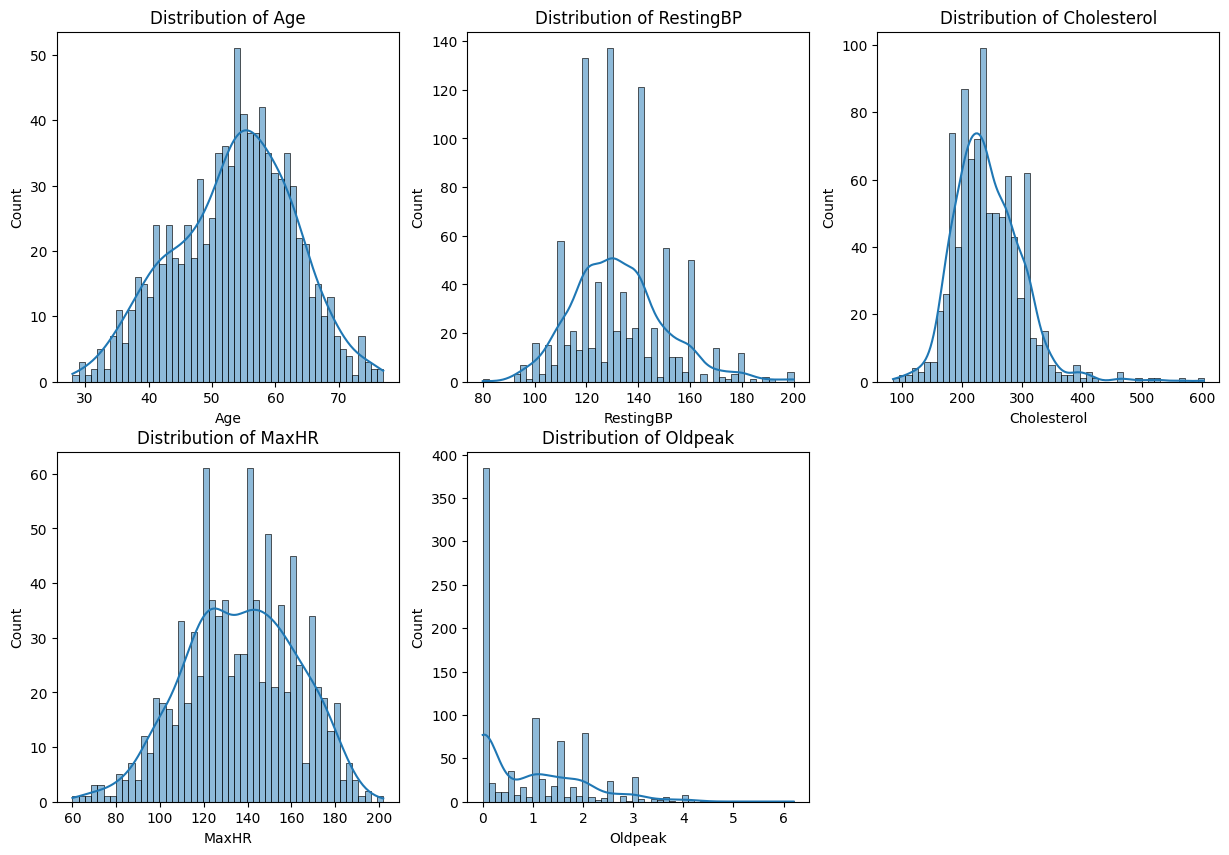

In [18]:
#Having another look at the distribution
plt.figure(figsize=(15, 10))


numerical_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(dataset[col], kde=True, bins=50)
    plt.title("Distribution of {}".format(col))

plt.show()

Outliers per feature:
Age             0
RestingBP      27
Cholesterol    23
MaxHR           2
Oldpeak        15
dtype: int64


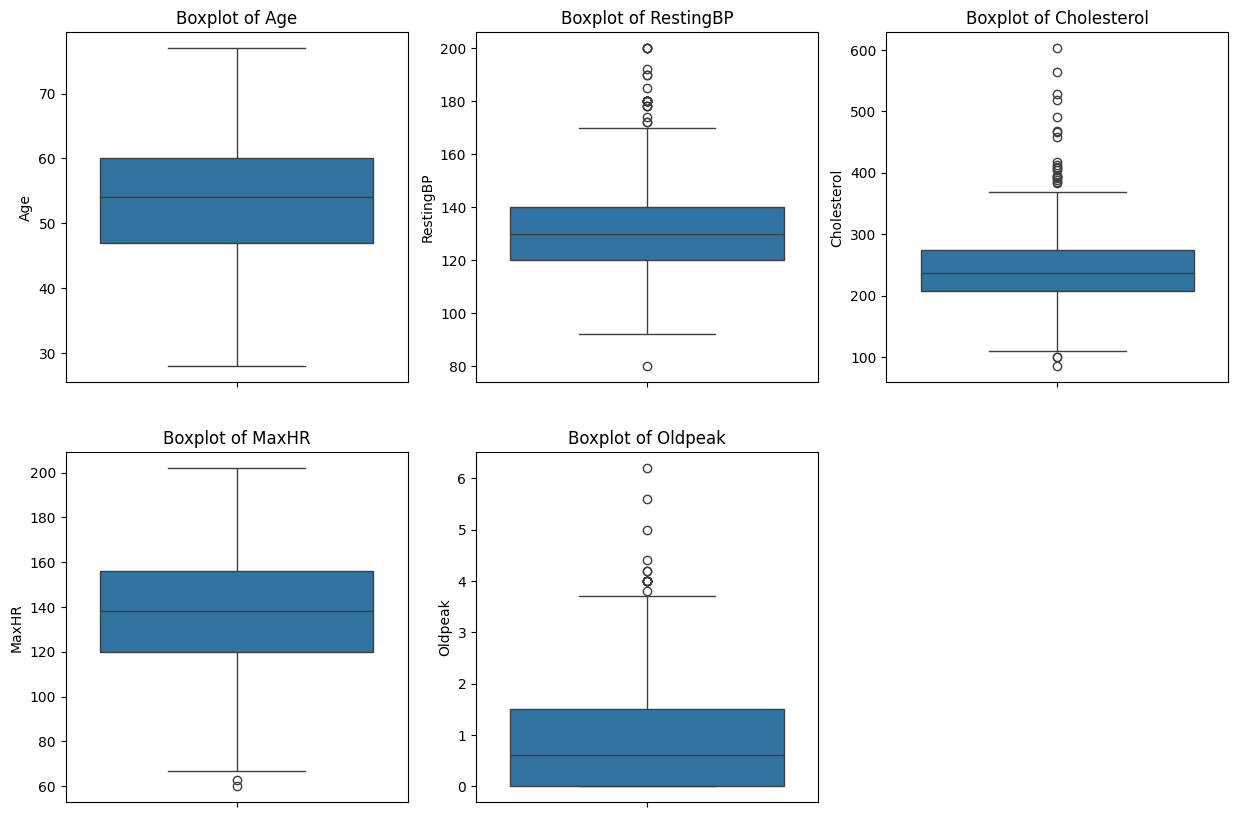

In [19]:
plt.figure(figsize=(15, 10))


numerical_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=dataset[col])
    plt.title(f"Boxplot of {col}")

    
#Inter quartile outliers
Q1 = dataset[numerical_features].quantile(0.25)
Q3 = dataset[numerical_features].quantile(0.75)
IQR = Q3 - Q1

outliers = (dataset[numerical_features] < (Q1 - (1.5 * IQR))) | (dataset[numerical_features] > (Q3 + (1.5 * IQR)))
print("Outliers per feature:")
print(outliers.sum())

plt.show()

In [20]:
#Cap features with outliers to the 1st and 99th percentiles
outlier_features = ["Cholesterol", "RestingBP", "Oldpeak"]

for i, col in enumerate(outlier_features, 1):
    lower_bound = dataset[col].quantile(0.01)
    upper_bound = dataset[col].quantile(0.99)
    dataset[col] = dataset[col].clip(lower=lower_bound, upper=upper_bound)

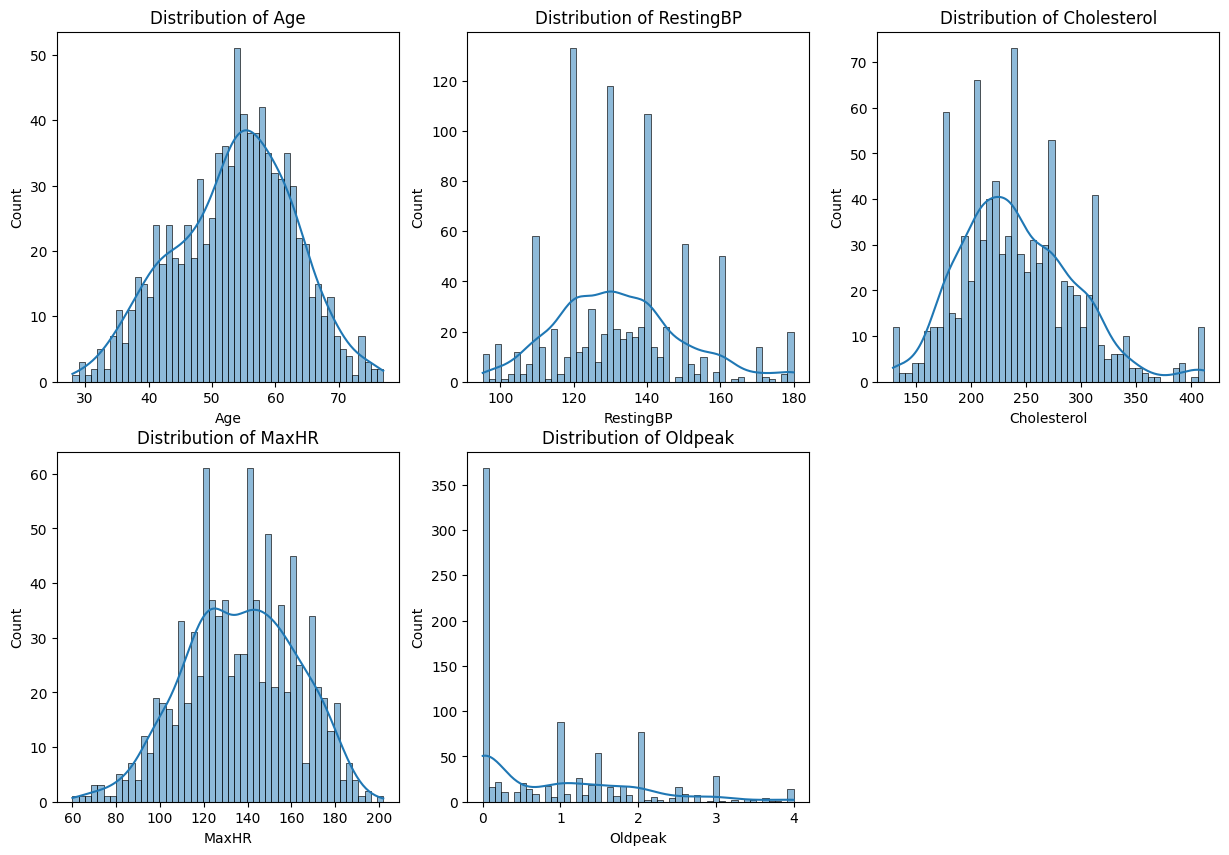

In [21]:
#Having another look at the distribution
plt.figure(figsize=(15, 10))


numerical_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(dataset[col], kde=True, bins=50)
    plt.title("Distribution of {}".format(col))

plt.show()

Oldpeak clearly has some issues and is heavily skewed with almost 400 counts of 0. The problem is 0 is a valid value and can be 0 in healthy individuals. 

However there is a precedent for missing data (as evidenced by 173 values for cholesterol being 0) in the dataset. 

The only safe bet that I can think of is creating new features to represent the possibility of missing data.

In [22]:
dataset["Oldpeak_Binned"] = pd.cut(dataset["Oldpeak"], bins=[-0.1, 0, 1, 2, 3, 6.2], labels=[0, 1, 2, 3, 4])

dataset["Oldpeak_Missing"] = (dataset["Oldpeak"] == 0).astype(int)

## Feature Selection

For Random Forest, Feature Selection isn't very important. From preliminary EDA, not many features are highly correlated.

However, feature selection for QML will become important at a later time

## Feature Engineering

Categorical variables were already encoded earlier

### Creation of new Features

Summary:
<ol>
    <li>Oldpeak_Binned to deal with the skewness</li>
    <li>Oldpeak_Missing to indicate when Oldpeak == 0. This could possibly represent potential missing data</li>
    <li>Age Groups (Binning Age)</li>
    <li>Cholesterol to Age Ratio. This could indicate the severity of cholestrol and younger and older ages</li>
    <li>Combining RestingBP and Cholesterol. In my mind, resting blood pressure and cholesterol have some form of interaction</li>
</ol>

In [23]:
#Age Groups

dataset["AgeGroup"] = pd.cut(dataset["Age"], bins=[20, 35, 50, 65, 100], labels=["0", "1", "2", "3"])
#The labels represent [Under 35s, Over 35s, Over 50s, Over 65s]

In [24]:
#Cholesterol to Age Ratio
#This could indicate the severity of cholestrol at younger and older ages

dataset["Cholesterol_Age_Ratio"] = dataset["Cholesterol"] / dataset["Age"]

In [25]:
#Combining RestingBP and Cholesterol
#In my mind, resting blood pressure and cholesterol have some form of interaction

dataset["Cholesterol_RestingBP"] = dataset["Cholesterol"] * dataset["RestingBP"]

In [26]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
HeartDisease,918.0,0.553377,0.497414,0.000000,0.000000,1.000000,1.000000,1.000000
Age,918.0,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
ChestPainType,918.0,0.748366,0.931031,0.000000,0.000000,0.000000,1.000000,3.000000
RestingBP,918.0,132.423420,17.535784,95.170000,120.000000,130.000000,140.000000,180.000000
Cholesterol,918.0,242.258497,52.847809,129.340000,207.000000,237.000000,275.000000,411.490000
FastingBS,918.0,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,918.0,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
Oldpeak,918.0,0.909150,1.019859,0.000000,0.000000,0.600000,1.500000,4.000000
ST_Slope,918.0,1.361656,0.607056,0.000000,1.000000,1.000000,2.000000,2.000000
Sex_M,918.0,0.789760,0.407701,0.000000,1.000000,1.000000,1.000000,1.000000


### Feature Scaling

Feature Scaling is not needed for Random Forest

## Class Imbalance

There is only a moderate class imbalance, so resampling may not be required

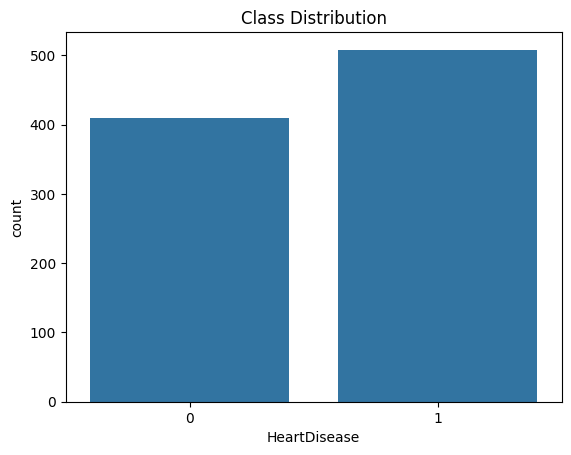

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [27]:
sns.countplot(x=dataset["HeartDisease"])
plt.title("Class Distribution")
plt.show()
dataset["HeartDisease"].value_counts()

Because of the imbalance, performance metrices that exclude accuracy would be more indicative of performance

# Classical Classification

I'm using random forest, here are the specifications:

<ol>
    <li>Data is split 70 : 30 and stratified</li>
    <li>There are 10 runs with different splits and trainings with aggregated performance metrics to remove the randomness</li>
    <li>The classifier is grid searched (with k-fold cross validation) on training data and has a tight hyper parameter range due to a lot of fine-tuning (It also overfits if given the range to move around). The current hyper-parameters do well to reduce overfitting, improve generalisation and mitigate the class imbalance effectively</li>
    <li>Several performance metrics are measured on fully separated test data which will be expanded upon at evalution</li>
</ol>

In [28]:
import sklearn
import sklearn.ensemble
import sklearn.model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, log_loss

In [29]:
#Evaluation Metrics
class EvalMetrics():
    def __init__(self):
        #Performance Metrics
        self.metrics = {
            "train_accuracy": [], "train_precision": [], "train_recall": [], "train_f1": [], "train_roc_auc": [], "train_pr_auc": [], "train_log_loss": [],
            "test_accuracy": [], "test_precision": [], "test_recall": [], "test_f1": [], "test_roc_auc": [], "test_pr_auc": [], "test_log_loss": [],
            "compute_time": []
        }
        #Confusion matrices that will be aggregated to
        self.train_cf_matrix_sum = np.zeros((2, 2))
        self.test_cf_matrix_sum = np.zeros((2, 2))
    
        self.pickle_info = {}
        
    def set_pickle_info(self, n_qubits, n_layers_encoding, n_layers_ansatz, shots, n_runs, batch_size, num_epochs, circuit, opt_type):
        self.pickle_info["n_qubits"] = n_qubits
        self.pickle_info["n_layers_encoding"] = n_layers_encoding
        self.pickle_info["n_layers_ansatz"] = n_layers_ansatz
        self.pickle_info["shots"] = shots
        self.pickle_info["n_runs"] = n_runs
        self.pickle_info["batch_size"] = batch_size
        self.pickle_info["num_epochs"] = num_epochs
        self.pickle_info["circuit"] = circuit.__name__
        self.pickle_info["opt_type"] = opt_type

    def add_predictions(self, y_train, y_train_pred, y_train_pred_proba, y_test, y_test_pred, y_test_pred_proba, compute_time):
        #Store Performance Metrics
        self.metrics["train_accuracy"].append(accuracy_score(y_train, y_train_pred))
        self.metrics["train_precision"].append(precision_score(y_train, y_train_pred))
        self.metrics["train_recall"].append(recall_score(y_train, y_train_pred))
        self.metrics["train_f1"].append(f1_score(y_train, y_train_pred))
        self.metrics["train_roc_auc"].append(roc_auc_score(y_train, y_train_pred_proba))
        self.metrics["train_pr_auc"].append(average_precision_score(y_train, y_train_pred_proba))
        self.metrics["train_log_loss"].append(log_loss(y_train, y_train_pred_proba))

        self.metrics["test_accuracy"].append(accuracy_score(y_test, y_test_pred))
        self.metrics["test_precision"].append(precision_score(y_test, y_test_pred))
        self.metrics["test_recall"].append(recall_score(y_test, y_test_pred))
        self.metrics["test_f1"].append(f1_score(y_test, y_test_pred))
        self.metrics["test_roc_auc"].append(roc_auc_score(y_test, y_test_pred_proba))
        self.metrics["test_pr_auc"].append(average_precision_score(y_test, y_test_pred_proba))
        self.metrics["test_log_loss"].append(log_loss(y_test, y_test_pred_proba))
        
        self.metrics["compute_time"].append(compute_time)
        #Accumulate confusion matrices
        self.train_cf_matrix_sum += confusion_matrix(y_train, y_train_pred)
        self.test_cf_matrix_sum += confusion_matrix(y_test, y_test_pred)
    
    
    def plot_confusion_matrix(self, cf, subplot_index, title):
        plt.subplot(1, 2, subplot_index)
        sns.heatmap(cf, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(title)
    
    def print_metrics(self):
        #Compute mean and standard deviations
        metrics_mean = {}
        metrics_std = {}
        for key, values in self.metrics.items():
            metrics_mean[key] = np.mean(values)
            metrics_std[key] = np.std(values)

        #Print averaged Performance Metrics
        print("\nAveraged Performance Metrics Over", self.pickle_info["n_runs"], "Runs:")
        print(f"Train Accuracy: {metrics_mean['train_accuracy']:.4f} ± {metrics_std['train_accuracy']:.4f}\t\t\t\t Test Accuracy: {metrics_mean['test_accuracy']:.4f} ± {metrics_std['test_accuracy']:.4f}")
        print(f"Train Precision: {metrics_mean['train_precision']:.4f} ± {metrics_std['train_precision']:.4f}\t\t\t Test Precision: {metrics_mean['test_precision']:.4f} ± {metrics_std['test_precision']:.4f}")
        print(f"Train Recall: {metrics_mean['train_recall']:.4f} ± {metrics_std['train_recall']:.4f}\t\t\t\t Test Recall: {metrics_mean['test_recall']:.4f} ± {metrics_std['test_recall']:.4f}")
        print(f"Train F1-score: {metrics_mean['train_f1']:.4f} ± {metrics_std['train_f1']:.4f}\t\t\t\t Test F1-score: {metrics_mean['test_f1']:.4f} ± {metrics_std['test_f1']:.4f}")
        print(f"Train ROC AUC: {metrics_mean['train_roc_auc']:.4f} ± {metrics_std['train_roc_auc']:.4f}\t\t\t\t Test ROC AUC: {metrics_mean['test_roc_auc']:.4f} ± {metrics_std['test_roc_auc']:.4f}")
        print(f"Train Precision-Recall AUC: {metrics_mean['train_pr_auc']:.4f} ± {metrics_std['train_pr_auc']:.4f}\t\t Test Precision-Recall AUC: {metrics_mean['test_pr_auc']:.4f} ± {metrics_std['test_pr_auc']:.4f}")
        print(f"Train Log Loss: {metrics_mean['train_log_loss']:.4f} ± {metrics_std['train_log_loss']:.4f}\t\t\t\t Test Log Loss: {metrics_mean['test_log_loss']:.4f} ± {metrics_std['test_log_loss']:.4f}")
        print(f"Compute Time: {metrics_mean['compute_time']:.4f} ± {metrics_std['compute_time']:.4f}")

        #Confusion Matrices
        plt.figure(figsize=(12, 4))

        #Normalise confusion matrices
        train_cf_matrix_avg = (self.train_cf_matrix_sum / self.train_cf_matrix_sum.sum()) * 100
        test_cf_matrix_avg = (self.test_cf_matrix_sum / self.test_cf_matrix_sum.sum()) * 100

        self.plot_confusion_matrix(train_cf_matrix_avg, 1, "Train Confusion Matrix")
        self.plot_confusion_matrix(test_cf_matrix_avg, 2, "Test Confusion Matrix")
        plt.show()

In [30]:
#Grid Search Hyper-Parameters
RFC = sklearn.ensemble.RandomForestClassifier()
param_grid = {
    'class_weight': ["balanced"],
    'bootstrap': [True, False],
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': [20, 22],
    'max_features': [4, 5, 6, 7, 8],
    'min_samples_leaf': [30],
    'min_samples_split': [4],
    'min_weight_fraction_leaf': [0.01],
    'ccp_alpha': [0.001],
    'n_estimators': [80]
}

In [31]:
n_runs = 10

#Performance Metrics
Metrics = EvalMetrics()
Metrics.pickle_info["n_runs"] = n_runs

for i in range(n_runs):
    print(f"Run {i+1}/{n_runs}: ")
    
    
    #Split Dataset
    X = dataset[dataset.columns[1:]]
    y = dataset["HeartDisease"]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size = 0.7, stratify = y)
    
    #Grid Search
    grid_search_results = sklearn.model_selection.GridSearchCV(estimator=RFC, param_grid=param_grid, cv=5, verbose = 3, n_jobs = -1)
    grid_search_results.fit(X_train, y_train)
    
    #Grid Search's best estimator
    best_grid = grid_search_results.best_estimator_

    print("Best Parameters: {}".format(grid_search_results.best_params_))
    compute_time = np.sum(grid_search_results.cv_results_['mean_fit_time'])
    print("Took {:.0f} Seconds\n".format(compute_time))
    
    
    #Predictions
    y_train_pred = best_grid.predict(X_train)
    y_train_pred_proba = best_grid.predict_proba(X_train)[:, 1]

    y_test_pred = best_grid.predict(X_test)
    y_test_pred_proba = best_grid.predict_proba(X_test)[:, 1]
    
    
    #Store Performance Metrics
    Metrics.add_predictions(y_train, y_train_pred, y_train_pred_proba, y_test, y_test_pred, y_test_pred_proba, compute_time)

Run 1/10: 
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 20, 'max_features': 6, 'min_samples_leaf': 30, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 80}
Took 10 Seconds

Run 2/10: 
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 22, 'max_features': 5, 'min_samples_leaf': 30, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 80}
Took 10 Seconds

Run 3/10: 
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 30, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 80}
T

## Performance Metrics

These performance metrics were considered taking to account the slight class imbalance in the data; ~55% : ~45% positive label.

<ol>
    <li>Accuracy: Not the most meaningful metric given the imbalance</li>
    <li>Precision: Evaluates the quality of positive predictions</li>
    <li>Recall: Becomes important when you want to capture as many positive instances as possible.</li>
    <li>F1-Measure: Balances Precision and Recall</li>
    <li>Area Under the Receiving Operating Characteric Curve: Great metric for assessing overall discriminability</li>
    <li>Area Under the Precision-Recall Curve: Directly measures ability to identify the minority class</li>
    <li>Log Loss: Penalises high confidence (probability) in incorrect predictions</li>
    <li>Confusion Matrix: Summary of the True Positives, True Negatives, False Positives and False Negatives</li>
</ol>


Averaged Performance Metrics Over 10 Runs:
Train Accuracy: 0.8662 ± 0.0082				 Test Accuracy: 0.8529 ± 0.0165
Train Precision: 0.8756 ± 0.0081			 Test Precision: 0.8706 ± 0.0242
Train Recall: 0.8837 ± 0.0155				 Test Recall: 0.8641 ± 0.0237
Train F1-score: 0.8795 ± 0.0080				 Test F1-score: 0.8669 ± 0.0147
Train ROC AUC: 0.9406 ± 0.0049				 Test ROC AUC: 0.9258 ± 0.0107
Train Precision-Recall AUC: 0.9470 ± 0.0062		 Test Precision-Recall AUC: 0.9323 ± 0.0132
Train Log Loss: 0.3486 ± 0.0126				 Test Log Loss: 0.3759 ± 0.0180
Compute Time: 10.4253 ± 0.4371


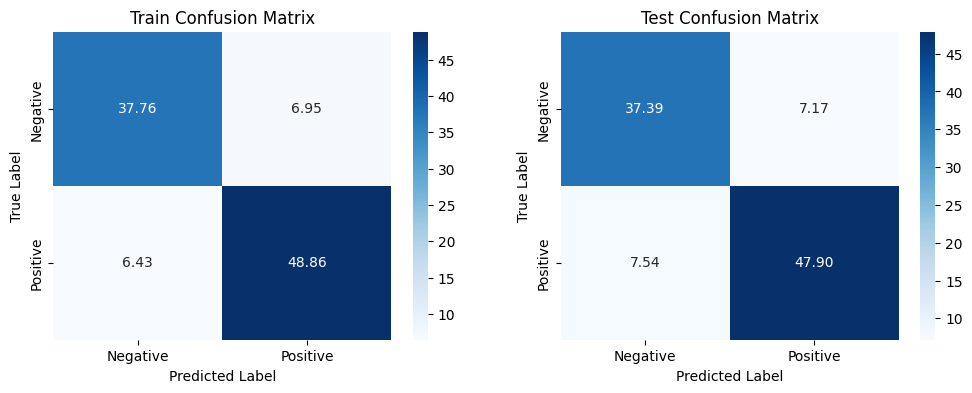

In [32]:
Metrics.print_metrics()

KNN:

Averaged Performance Metrics Over 10 Runs:
Train Accuracy: 0.8637 ± 0.0066				 Test Accuracy: 0.8522 ± 0.0158
Train Precision: 0.8738 ± 0.0084			 Test Precision: 0.8657 ± 0.0150
Train Recall: 0.8808 ± 0.0098				 Test Recall: 0.8686 ± 0.0341
Train F1-score: 0.8773 ± 0.0060				 Test F1-score: 0.8667 ± 0.0163
Train ROC AUC: 0.9382 ± 0.0055				 Test ROC AUC: 0.9242 ± 0.0077
Train Precision-Recall AUC: 0.9443 ± 0.0077		 Test Precision-Recall AUC: 0.9270 ± 0.0122
Train Log Loss: 0.3573 ± 0.0127				 Test Log Loss: 0.3808 ± 0.0110

## Interpretation of Results

The model generalises well and does not overfit the training data (too much)

# Quantum Plan

<ol>
    <li>Plan A: Do Pennylane to get faster things going which will enable wider, deeper, and higher iteration circuits with less experimentation</li>
    <li>Plan B: Give up on Pennylane and do Qiskit with lots of experimentation of random things that may or may not work.</li>
</ol>


The challenging aspects of the data:

<ul>
    <li>The large number of features for 1 qubit per feature</li>
    <li>The mixed data, particularly the nominal categorical variables for rotation encoding</li>
    <li>The class imbalance. Although it is minor, could still potentially bias a quantum model</li>
    <li>There are still outliers in the data due to my conservative approach to clip the data at the 1st and 99th percentiles</li>
</ul>

## Data Preparation

Most of the data prep work is done

### Feature Selection

Random Forest feature importance is a good jumping off point. 

Evidently from the next graph, some features can be thrown away because they are completely useless

I can first test with top 3-5 most important features then later experiment with using the whole feature set

To encode more features, I will probably have to employ PCA

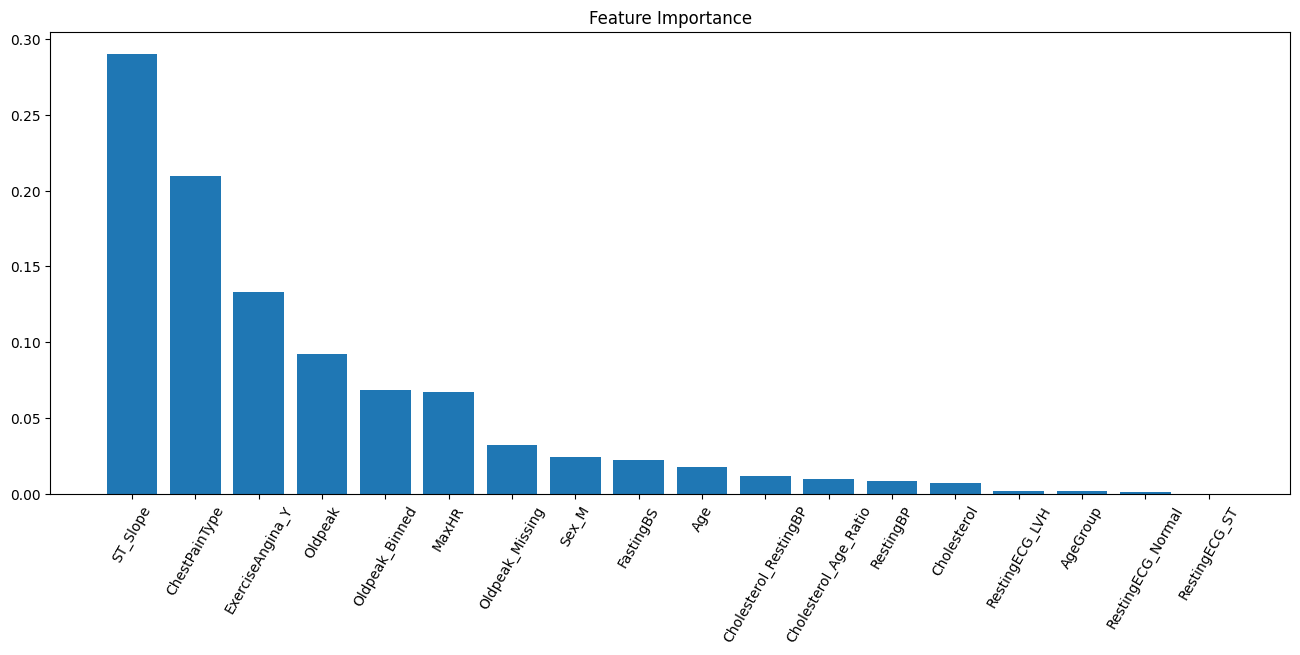

In [33]:
plt.figure(figsize=(16, 6))
importances = best_grid.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=60)


plt.show()

### Feature Engineering

Rotation encoding seems the most sensible as the number of useful features I have seem to be small
<ol>
    <li>Normalisation of features between $0$ and $2\pi$</li>
    <li>Padding around $0$ and $2\pi$ as they are the same value</li>
    <li>I can also experiment with sklearn.preprocessing.PolynomialFeatures to introduce more non-linearity</li>
</ol>

## Data Encoding

Number of qubits used would be between 3 and 5 as a start. Obviously, the less qubits, the better the turnaround time for testing.

<ol>
    <li>I want to try having two different data encoding ansatze one after the other which will probably perform badly, but I'm curious</li>
    <li>The possibility of reducing number of qubits by encoding more than 1 feature onto the same wire</li>
    <li>I'll also experiment with having trainable parameters inside the ZZFeaturemap ansatz (or something similar) similar to the examples seen in literature I've looked at so far</li>
</ol>

## Ansatz

The way I can think to do this step would be to experiment loads of different Ansatz. As I can't figure out if there is a "best" one for my case and my dataset
<ol>
    <li>I intend to experiment with few different Ansatz models seen in the literature that other people have used and possibly add a couple tweaks to it just to see if there is any difference</li>
    <li>I also want to experiment with using Ry, Rz gates in tandem (-- entangle -- Rx -- Ry -- entangle -- etc.) as it seems to be more expressive</li>
    <li>A good place to start would be to take inspiration from Qiskit's RealAmplitudes and EfficientSU2</li>
</ol>

To me, it seems this important step of the model isn't very clear-cut and will result in a lot of trial and error.

In [34]:
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit import QuantumCircuit

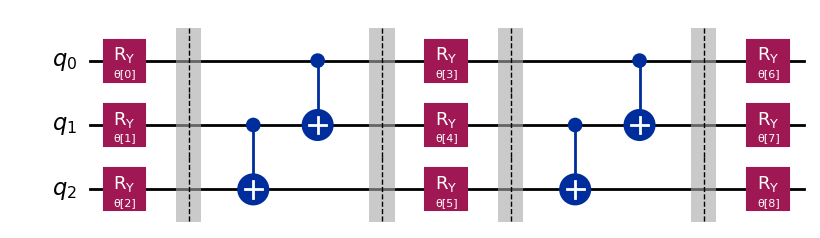

In [35]:
ansatz = RealAmplitudes(3, reps=2, insert_barriers=True)
qc = QuantumCircuit(3)
qc.compose(ansatz, inplace=True)
qc.decompose().draw("mpl")

plt.show()

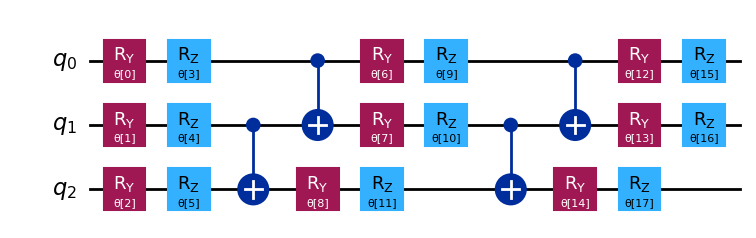

In [36]:
ansatz = EfficientSU2(3, reps=2)
qc = QuantumCircuit(3)
qc.compose(ansatz, inplace=True)
qc.decompose().draw("mpl")

plt.show()

## Output Decoding

For my case with binary classification, the easiest way I can think to do the output decoding step will based on the parity of the measured bitstring from the qubits. (e.g. 000 = class 0, 001 = class 1) 

Then, expectation values and probability distributions can be constructed (with sufficient number of shots) and used to calculate the loss



## Optimisation

Cost Function: Binary Cross Entropy for gradient descent (e.g. ADAM)

Then parameters are iteratively updated

I should also experiment with gradient-free optimisers

A small ambiguity I have is whether I should implement the optimiser myself or use Pennylane/Qiskit optimisers

## Running on Real Quantum Computers

On https://quantum.ibm.com/, it tells me I have 10 minutes of free compute time. My initial assumption is that I will experiment with my design with simulated backends and run the design that performs the best or gives me the most insight. 

I'll also look into using Azure.

I don't really know how much 10 minutes is, so the best I can do is be cautious and use it wisely.

Hopefully before 2 week break is over, I'll have at least attempted to run something on a real device

# Key Resources that will support the project

Pennylane Tutorials/documentation on their website or Youtube

Literature for ansatze and optimisers

Patience

# Quantum Implementation

## Overview

My implementation uses pennylane and as there is no built-in VQC, I constructed one myself.

This task was more difficult than expected and didn't allow me as much time for experimentation as I wanted. However, I did manage to acquire 60 hours worth of grid-search-like evaluation data, despite the small search space.

In [37]:
#pip install pennylane
#!pip install pennylane-qiskit
#!pip install jax

In [38]:
import pennylane as qml
import numpy as np
from pennylane import numpy as qnp
from pennylane.optimize import AdamOptimizer

import torch
import torch.nn as nn
from torch.optim import Adam

import pickle
import time

In [113]:
#Basic method for one layer of entanglement
def entangle_layer():
    """  """
    for i in range(n_qubits-1):
        qml.CNOT(wires = [i, (i+1) % n_qubits])

#### Data Encoding approaches with function for normalising data between $0$ and $2\pi$

<ul>
    <li>X gates with entanglement between layers</li>
    <li>X gates with trainable weights straight after</li>
    <li>Y and Z gates with sin() and cos() respectively</li>
</ul>

In [114]:
#The nominal features are terrible in the dataset so haven't implemented normalisation for those
def data_normalise(row, padding=0.8, opt_type="torch"):
    """ 
    Min-Max normalisation between (padding, 2pi - padding)
    """
    if opt_type=="torch":
        row = torch.tensor(row)
        #Get column mins and maxes for normalisation
        column_mins = row.min(dim = 0).values
        column_maxes = row.max(dim = 0).values
        column_ranges = column_maxes - column_mins
        column_ranges[column_ranges == 0] = 1 #Prevent division by 0 as per formula

    else:
        row = qnp.array(row)
        #Get column mins and maxes for normalisation
        column_mins = qnp.min(row, axis=0)
        column_maxes = qnp.max(row, axis=0)
        # Avoid division by zero
        column_ranges = column_maxes - column_mins
        column_ranges = qnp.where(column_ranges == 0, 1.0, column_ranges)


    #Min max 
    normalised = ((row - column_mins) / column_ranges) * (2*np.pi - 2*padding) + padding
    return normalised


def basic_state_prep(datapoint):
    """Basic data encoding into Rx gates"""
    #SuperPosition
    for i in range(n_qubits):
        qml.H(wires=i)
    for i in range(n_layers_encoding):
        for j in range(n_qubits):
            qml.RX(datapoint[j], wires=j)
        entangle_layer()
        
def reup_state_prep(datapoint, params):
    """Variation of data reuploading
    Loads all feature data with trainable weights onto wires with overlapping if needed"""
    for i in range(n_qubits):
        qml.H(wires=i)
    for i in range(n_layers_encoding):
        for j in range(len(datapoint)):
            qml.RX(datapoint[j], wires = j % n_qubits)
            qml.RY(params[len(params)-1 - (j + i*len(datapoint))], wires = j % n_qubits)
            
            if j % n_qubits == n_qubits-1:
                entangle_layer()
                
        if len(datapoint) % 2 != 0 and len(datapoint) != n_qubits:
            entangle_layer()
            
def fourier_state_prep(datapoint):
    """Fourier Inspired Encoding"""
    #SuperPosition
    for i in range(n_qubits):
        qml.H(wires=i)
        
    for i in range(n_layers_encoding):
        for j in range(n_qubits):
            qml.RY(np.sin(datapoint[j]), wires=j)
            qml.RZ(np.cos(datapoint[j]), wires=j)
        
        entangle_layer()

#### Ansatz 

<ul>
    <li>Trainable Y Gates</li>
    <li>Trainable Y and Z Gates</li>
    <li>Trainable Z, Y and Z Gates</li>
</ul>

In [115]:
def RY_ansatz(params):
    """"""
    for i in range(n_layers_ansatz):
        for j in range(n_qubits):
            qml.RY(params[(i * n_qubits) + j], wires=j)
        entangle_layer()
        
        
def RYRZ_ansatz(params):
    """"""
    for i in range(n_layers_ansatz):
        for j in range(n_qubits):
            qml.RY(params[(i * 2 * n_qubits) + j], wires=j)
            qml.RZ(params[((i * 2 + 1) * n_qubits) + j], wires=j)
        entangle_layer()
        
        
def Rot_ansatz(params):
    """"""
    for i in range(n_layers_ansatz):
        for j in range(n_qubits):
            qml.Rot(params[((i * 3) * n_qubits) + j], params[((i * 3 + 1) * n_qubits) + j], params[((i * 3 + 2) * n_qubits) + j], wires=j)
        entangle_layer()

#### Circuit Definitions

<ul>
    <li>Basic X gates for state preparation followed by trainable Y gates</li>
    <li>Basic X gates for state preparation followed by trainable Y and Z gates</li>
    <li>Basic X gates for state preparation followed by trainable Z, Y and Z gates</li>
</ul>

In [116]:
n_qubits = 5
shots = 100
dev = qml.device("lightning.qubit",   wires=n_qubits, shots=shots)

@qml.qnode(dev, diff_method="best")
def basic_RY(datapoint, params):
    """ """
    basic_state_prep(datapoint)#Apply data encoding
    RY_ansatz(params)#Apply Ansatz
    return qml.probs(wires=[0])#Measure One Qubit
    
@qml.qnode(dev, diff_method="best")
def basic_RYRZ(datapoint, params):
    """ """
    basic_state_prep(datapoint)#Apply data encoding
    RYRZ_ansatz(params)
    return qml.probs(wires=[0])#Measure One Qubit
    
@qml.qnode(dev, diff_method="best")
def basic_Rot(datapoint, params): 
    """ """
    basic_state_prep(datapoint)#Apply data encoding
    Rot_ansatz(params)#Apply Ansatz
    return qml.probs(wires=[0])#Measure One Qubit

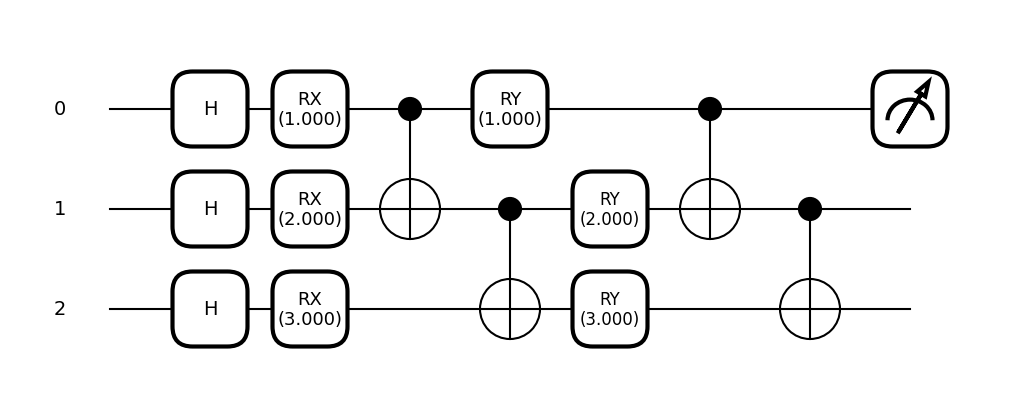

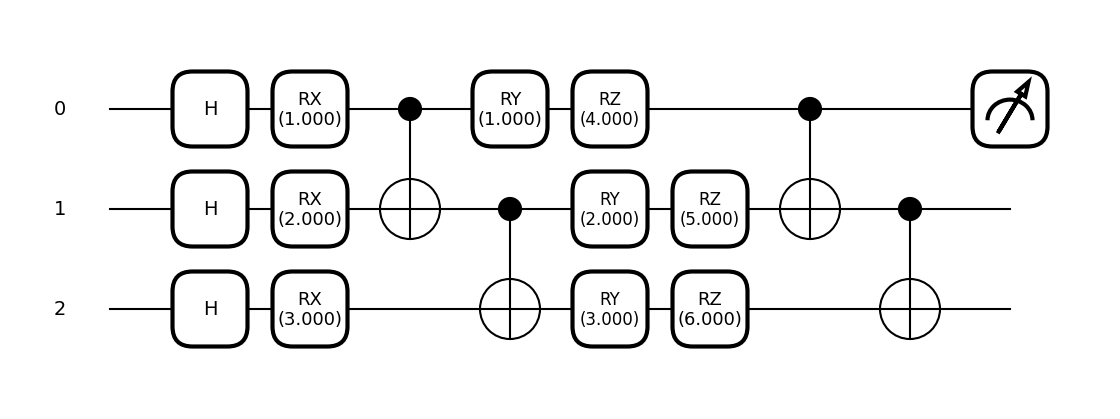

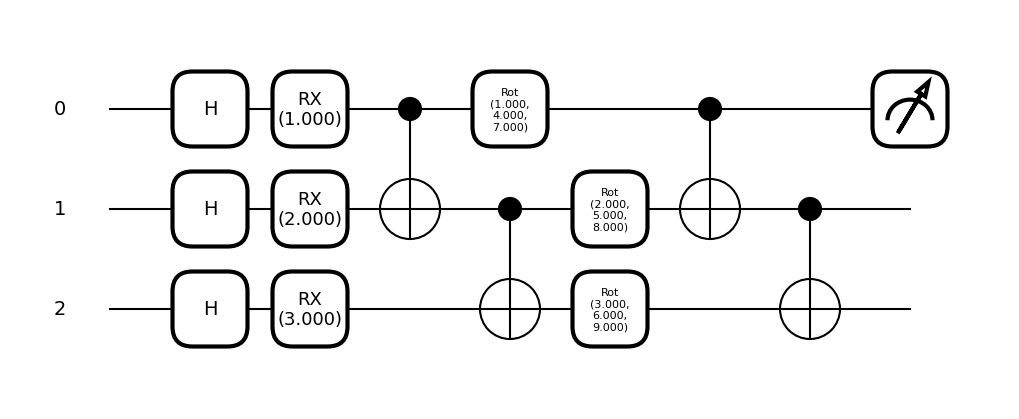

In [230]:
n_qubits = 3
n_layers_encoding = 1
n_layers_ansatz = 1
fig, ax = qml.draw_mpl(basic_RY, decimals=3)([1,2,3,], [1,2,3])
plt.show()

fig, ax = qml.draw_mpl(basic_RYRZ, decimals=3)([1,2,3], [1,2,3,4,5,6])
plt.show()

fig, ax = qml.draw_mpl(basic_Rot, decimals=3)([1,2,3], [1,2,3,4,5,6,7,8,9])
plt.show()

#### Circuit Definitions

<ul>
    <li>X gates followed by trainable Y Gates, then ansatz with trainable Y Gates</li>
    <li>X gates followed by trainable Y Gates, then ansatz with trainable Y and Z Gates</li>
    <li>X gates followed by trainable Y Gates, then ansatz with trainable Z, Y, and Z Gates</li>
</ul>

In [231]:
@qml.qnode(dev, diff_method="best")
def reup_RY(datapoint, params):
    """ """
    reup_state_prep(datapoint, params)#Apply data encoding
    RY_ansatz(params)#Apply Ansatz
    return qml.probs(wires=[0])#Measure One Qubit
    
@qml.qnode(dev, diff_method="best")
def reup_RYRZ(datapoint, params):
    """ """
    reup_state_prep(datapoint, params)#Apply data encoding
    RYRZ_ansatz(params)
    return qml.probs(wires=[0])#Measure One Qubit
    
@qml.qnode(dev, diff_method="best")
def reup_Rot(datapoint, params): 
    """ """
    reup_state_prep(datapoint, params)#Apply data encoding
    Rot_ansatz(params)#Apply Ansatz
    return qml.probs(wires=[0])#Measure One Qubit

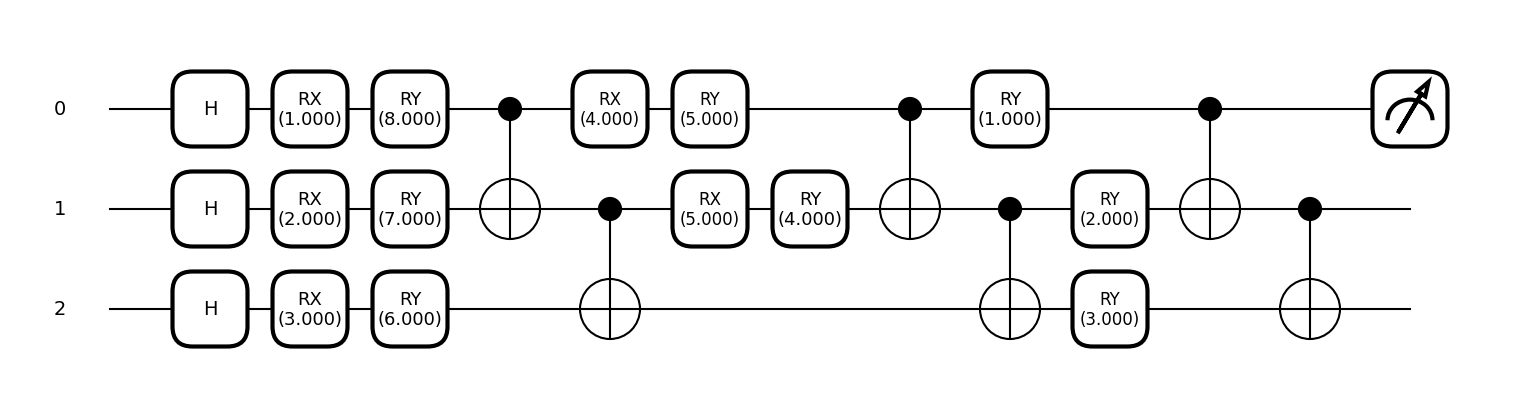

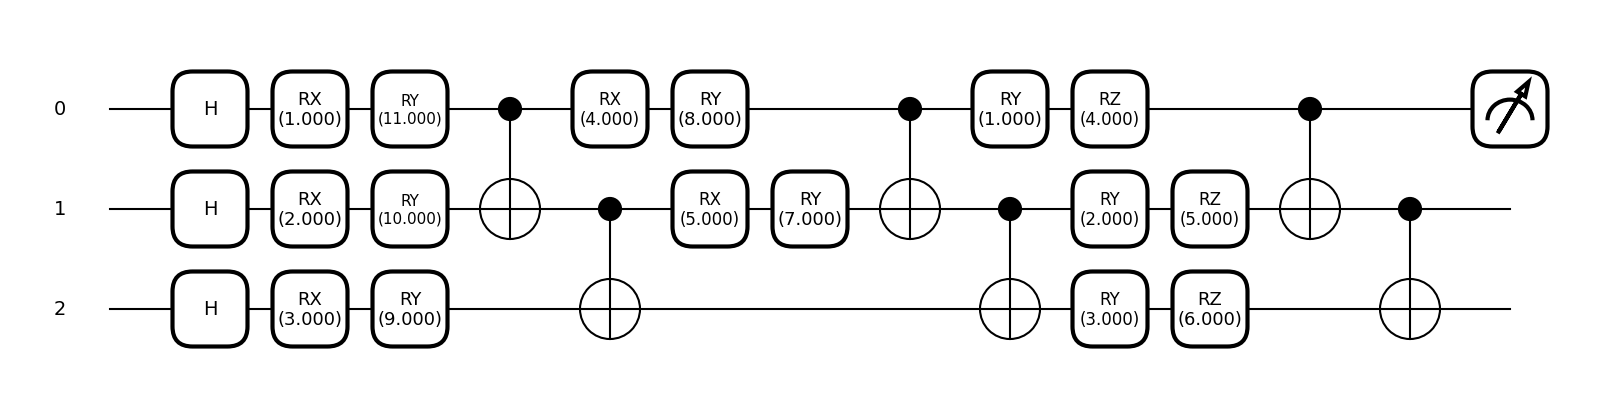

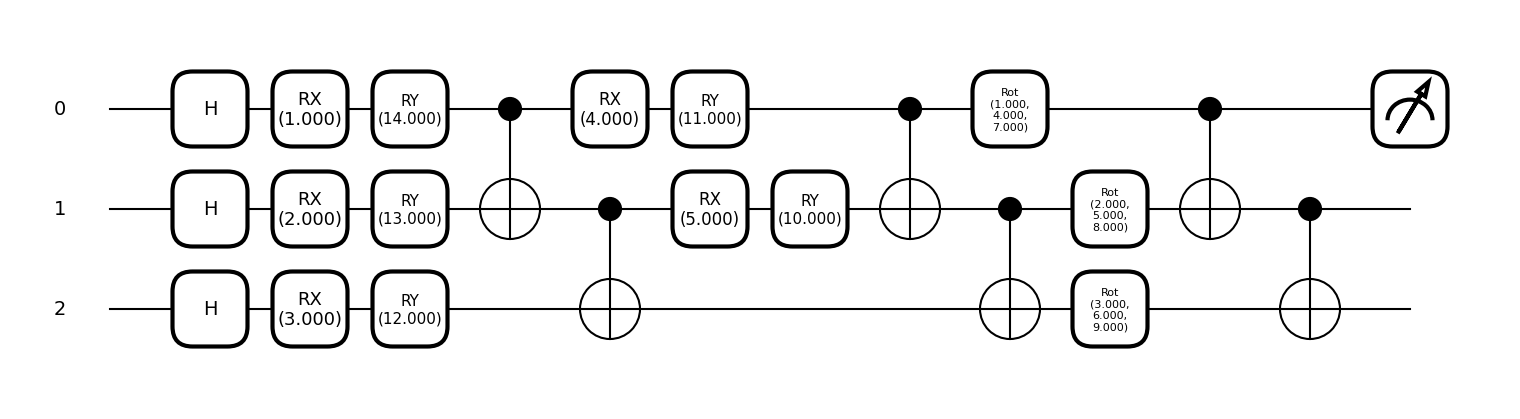

In [232]:
n_qubits = 3
fig, ax = qml.draw_mpl(reup_RY, decimals=3)([1,2,3,4,5], [1,2,3,4,5,6,7,8])
plt.show()

fig, ax = qml.draw_mpl(reup_RYRZ, decimals=3)([1,2,3,4,5], [1,2,3,4,5,6,7,8,9,10,11])
plt.show()

fig, ax = qml.draw_mpl(reup_Rot, decimals=3)([1,2,3,4,5], [1,2,3,4,5,6,7,8,9,9,10,11,12,13,14])
plt.show()

#### Circuit Definitions

<ul>
    <li>Y and Z gates with sin() and cos() followed by trainable Y Gates</li>
    <li>Y and Z gates with sin() and cos() followed by trainable Y and Z Gates</li>
    <li>Y and Z gates with sin() and cos() followed by trainable Z, Y and Z Gates</li>
</ul>

In [233]:
@qml.qnode(dev, diff_method="best")
def fourier_RY(datapoint, params): 
    """ """
    fourier_state_prep(datapoint)#Apply data encoding
    RY_ansatz(params)#Apply Ansatz
    return qml.probs(wires=[0])#Measure One Qubit

@qml.qnode(dev, diff_method="best")
def fourier_RYRZ(datapoint, params): 
    """ """
    fourier_state_prep(datapoint)#Apply data encoding
    RYRZ_ansatz(params)#Apply Ansatz
    return qml.probs(wires=[0])#Measure One Qubit

@qml.qnode(dev, diff_method="best")
def fourier_Rot(datapoint, params): 
    """ """
    fourier_state_prep(datapoint)#Apply data encoding
    Rot_ansatz(params)#Apply Ansatz
    return qml.probs(wires=[0])#Measure One Qubit

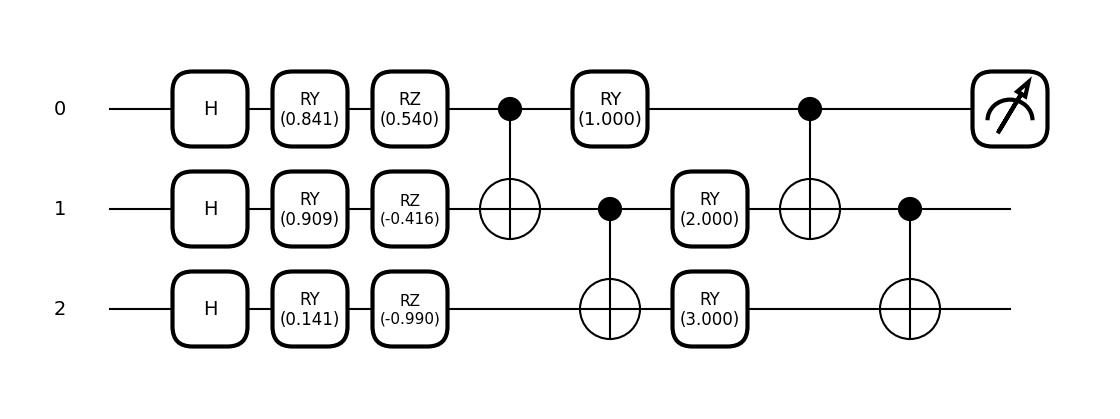

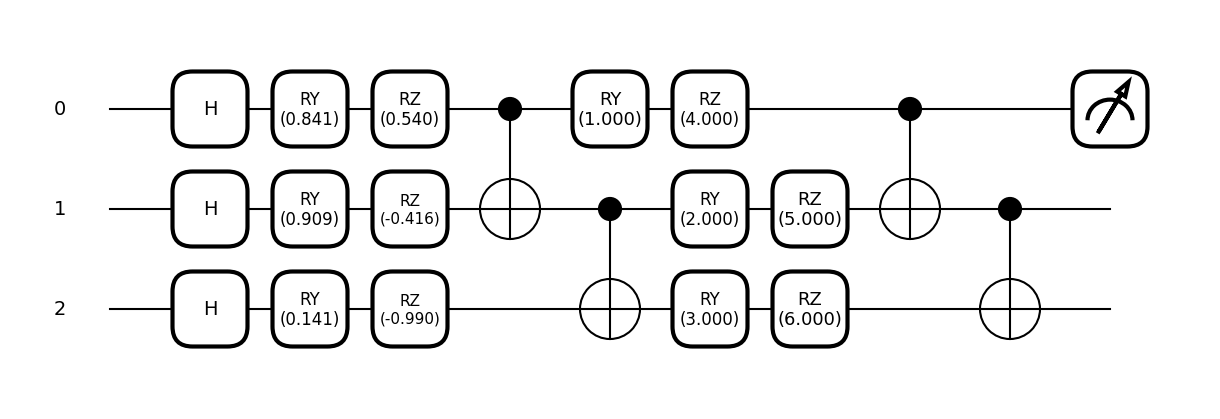

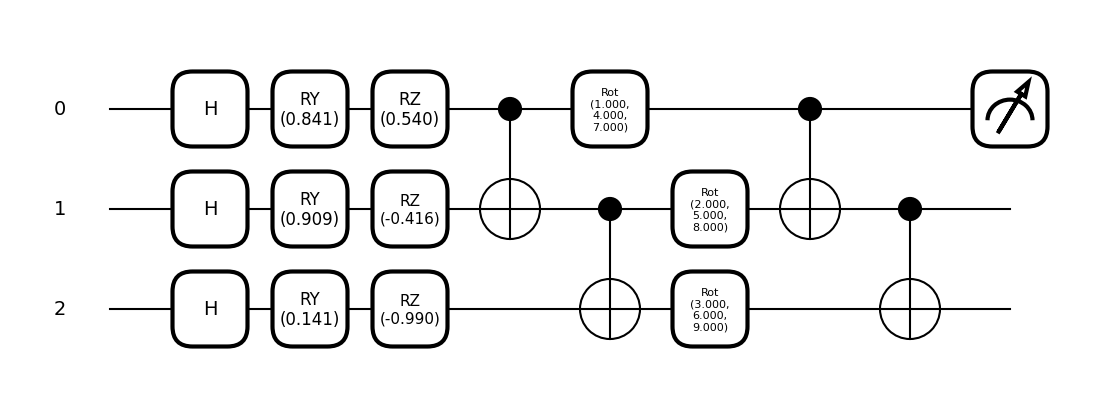

In [234]:
fig, ax = qml.draw_mpl(fourier_RY, decimals=3)([1,2,3], [1,2,3])
plt.show()

fig, ax = qml.draw_mpl(fourier_RYRZ, decimals=3)([1,2,3], [1,2,3,4,5,6])
plt.show()

fig, ax = qml.draw_mpl(fourier_Rot, decimals=3)([1,2,3], [1,2,3,4,5,6,7,8,9])
plt.show()

In [170]:
#Class that stores the circuits and also their weights
class CircuitConfig:
    def __init__(self, circuit, num_weights):
        self.circuit = circuit
        self.num_weights= num_weights
        
    def get_num_weights(self, n_qubits, n_layers_encoding, n_layers_ansatz):
        return self.num_weights(n_qubits, n_layers_encoding, n_layers_ansatz)
    
circuits = {"basic_RY": CircuitConfig(basic_RY, lambda q, e, a:   (e * 0) + (a * q * 1)),
            "basic_RYRZ": CircuitConfig(basic_RYRZ, lambda q, e, a: (e * 0) + (a * q * 2)),
            "basic_Rot": CircuitConfig(basic_Rot, lambda q, e, a: (e * 0) + (a * q * 3)),
            #5 for five features
            "reup_RY": CircuitConfig(reup_RY, lambda q, e, a: (e * 5) + (a * q * 1)),
            "reup_RYRZ": CircuitConfig(reup_RYRZ, lambda q, e, a: (e * 5) + (a * q * 2)),
            "reup_Rot": CircuitConfig(reup_Rot, lambda q, e, a: (e * 5) + (a * q * 3)),
            
            "fourier_RY": CircuitConfig(fourier_RY, lambda q, e, a: (e * 0) + (a * q * 1)),
            "fourier_RYRZ": CircuitConfig(fourier_RYRZ, lambda q, e, a: (e * 0) + (a * q * 2)),
            "fourier_Rot": CircuitConfig(fourier_Rot, lambda q, e, a: (e * 0) + (a * q * 3)),
}

circuits["reup_RYRZ"].get_num_weights(n_qubits=1, n_layers_encoding=1, n_layers_ansatz=1)

7

# Implementation of VQC

Consists Of:

<ul>
    <li>Cost function using Binary Cost Entropy Loss</li>
    <li>predict and predict_proba functions to predict class with and without probabilities</li>
    <li>Can be set to used either Torch Adam or Pennylane Adam. They are not compatible with each other</li>
    <li>Instead of batch learning, mini-batch is used instead. It is much faster and achieves the same if not better results</li>
</ul>

Initially, I struggled greatly getting the VQC to work well, as the metrics indicated that it classed labels randomly, no matter the variation in circuit design. 

This is because the circuits will always output a prediction between .4 and .6 (0 = class 0, 1 = class 1)

The solution is the implementation of temperature to exaggerate the prediction is the only thing that stops the vqc from being random

In [273]:
class VQC:
    def __init__(self, circuit, num_weights, opt_type="torch"):
        self.circuit = circuit
        self.opt_type = opt_type
        
        #Weight initialisation
        if self.opt_type == "torch":
            self.weights = torch.nn.Parameter(torch.empty(num_weights).uniform_(0+0.1, (2 * np.pi)-0.1), requires_grad=True)
        else:
            self.weights = qnp.array(np.random.uniform(0.1, 2 * np.pi - 0.1, size=num_weights), requires_grad=True)
        print(self.weights)
    
    
        #Optimiser Initialisation
        if self.opt_type == "torch":
            self.opt = torch.optim.Adam([self.weights], lr = 0.5)
        else:
            self.opt = AdamOptimizer(0.5)
            
    def cost(self, weights, X, Y):
        """Binary Cross Entropy Loss"""
        self.weights = weights
        predictions = self.predict_proba(X)
        y = Y
        
        if self.opt_type == "torch":
            y = y.to(torch.float64)
            loss_fn = nn.BCELoss()
            loss = loss_fn(predictions, y)
        else:
            #Custom BCELoss
            epsilon = 1e-8
            predictions = qml.math.clip(predictions, epsilon, 1 - epsilon)
            loss = -qml.math.mean(y * qml.math.log(predictions) + (1 - y) * qml.math.log(1 - predictions))
        return loss
    
    
    def predict(self, X):
        if self.opt_type == "torch":
            predictions = torch.stack([self.circuit(x, self.weights)[1] for x in X])
            temperature = 5.0  # Use same temperature as in training
            predictions = torch.sigmoid(temperature * (predictions - 0.5))
            return (predictions > 0.5).float()
        else:
            predictions = qnp.array([self.circuit(x, self.weights)[1] for x in X])
            temperature = 5.0  # Use same temperature as in training
            predictions = 0.5 * (qnp.tanh(temperature * (predictions - 0.5) / 2) + 1)
            return qml.math.cast(predictions > 0.5, dtype=qml.math.dtype("float64"))

    
    def predict_proba(self, X):
        if self.opt_type == "torch":
            predictions = torch.stack([self.circuit(x, self.weights)[1] for x in X])
        else:
            predictions = qnp.array([self.circuit(x, self.weights)[1] for x in X])

        temperature = 5.0  # Adjust this value to control separation
        predictions = 0.5 * (qml.math.tanh(temperature * (predictions - 0.5) / 2) + 1)
        return predictions
    
    
    def epoch_plot(self, epochs, losses):
        plt.clf()
        plt.plot(epochs, losses, label="Training Loss", marker="o", linestyle="-")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Live Training Loss")
        plt.legend()
        plt.show()
    
    #Return Compute Time
    def train(self, X, y, num_epochs, batch_size):
        epochs = []#For Plot
        losses = []
        
        #Draw an example of the circuit
        print("Circuit Example: ")
        fig, ax = qml.draw_mpl(self.circuit, decimals=3)(X_train[0], self.weights)
        plt.show()
        
        
        #Training
        start_time = time.time()
        for epoch in range(num_epochs):  
            batch_index = np.random.choice(len(X), size=batch_size, replace=False)
            X_batch = X[batch_index]
            y_batch = y[batch_index]

            if self.opt_type == "torch":
                self.opt.zero_grad()#Reset Gradients
                loss = self.cost(self.weights, X_batch, y_batch)#Calculate Loss
                loss.backward()#Loss Backprop
                self.opt.step()
                curr_loss = loss.item()
            else:
                self.weights = self.opt.step(vqc.cost, self.weights, X=X_batch, Y=y_batch)
                curr_loss = self.cost(self.weights, X_batch, y_batch)
                
                
            #print(self.weights)
            print(f"Epoch {epoch + 1}: Loss = {curr_loss:.2f}")
                
                
            epochs.append(epoch)#For plot
            losses.append(curr_loss)#For Plot
        end_time = time.time()
        print(f"Training Took: {end_time - start_time:.1f} Seconds")

        self.epoch_plot(epochs, losses)
        
        return end_time - start_time
            
    def test(self, X_train, X_test, y_train, y_test):
        if self.opt_type == "torch":
            #Predictions
            y_train_pred = self.predict(X_train).detach().numpy()
            y_train_pred_proba = self.predict_proba(X_train).detach().numpy()

            y_test_pred = self.predict(X_test).detach().numpy()
            y_test_pred_proba = self.predict_proba(X_test).detach().numpy()
        else:
            y_train_pred = self.predict(X_train).numpy()
            y_train_pred_proba = self.predict_proba(X_train).numpy()

            y_test_pred = self.predict(X_test).numpy()
            y_test_pred_proba = self.predict_proba(X_test).numpy()

        return y_train_pred, y_train_pred_proba, y_test_pred, y_test_pred_proba

The VQC is run and tested with data splits, performance metrics are recorded, and written to file with pickle

{'n_qubits': 2,
 'n_layers_encoding': 2,
 'n_layers_ansatz': 1,
 'shots': 100,
 'n_runs': 1,
 'batch_size': 3,
 'num_epochs': 12,
 'circuit': 'fourier_Rot',
 'opt_type': 'torch'}

Run 1/1: 
Parameter containing:
tensor([4.2481, 5.4960, 5.5001, 6.0437, 0.7471, 3.5492], requires_grad=True)
Circuit Example: 


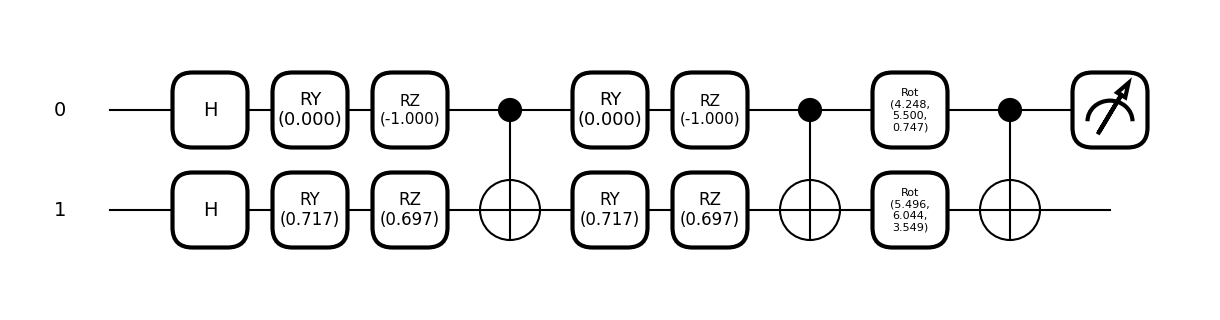

Epoch 1: Loss = 0.14
Epoch 2: Loss = 0.80
Epoch 3: Loss = 0.33
Epoch 4: Loss = 0.66
Epoch 5: Loss = 0.20
Epoch 6: Loss = 1.28
Epoch 7: Loss = 0.29
Epoch 8: Loss = 0.60
Epoch 9: Loss = 0.59
Epoch 10: Loss = 0.36
Epoch 11: Loss = 0.66
Epoch 12: Loss = 0.30
Training Took: 0.5 Seconds


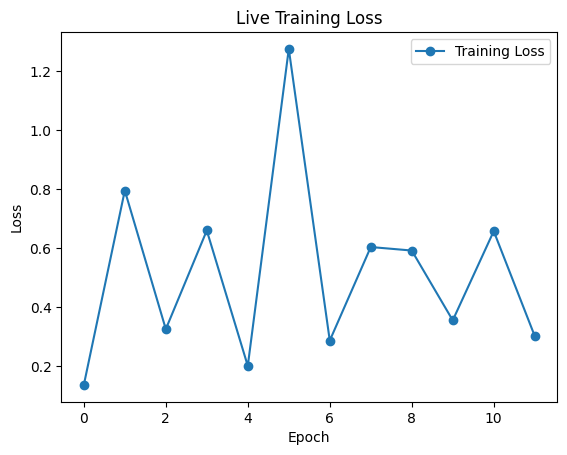


Averaged Performance Metrics Over 1 Runs:
Train Accuracy: 0.8069 ± 0.0000				 Test Accuracy: 0.8297 ± 0.0000
Train Precision: 0.8130 ± 0.0000			 Test Precision: 0.8442 ± 0.0000
Train Recall: 0.8451 ± 0.0000				 Test Recall: 0.8497 ± 0.0000
Train F1-score: 0.8287 ± 0.0000				 Test F1-score: 0.8469 ± 0.0000
Train ROC AUC: 0.8269 ± 0.0000				 Test ROC AUC: 0.8064 ± 0.0000
Train Precision-Recall AUC: 0.8494 ± 0.0000		 Test Precision-Recall AUC: 0.8038 ± 0.0000
Train Log Loss: 0.4888 ± 0.0000				 Test Log Loss: 0.4799 ± 0.0000
Compute Time: 0.4635 ± 0.0000


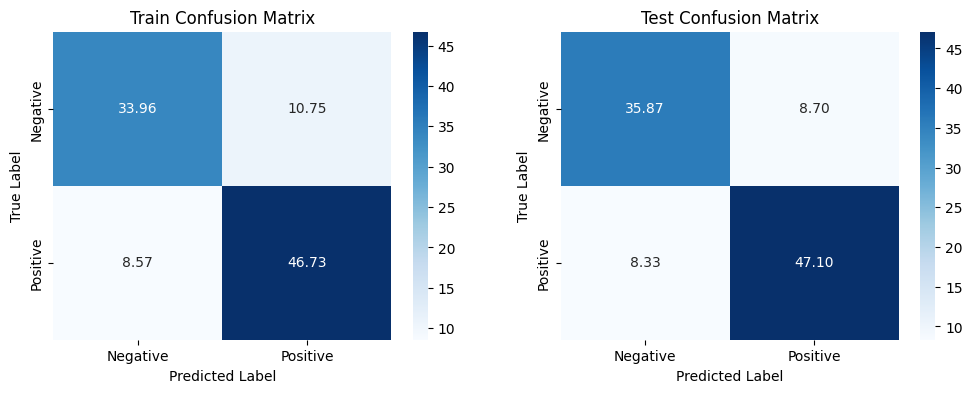

In [174]:
n_qubits = 2
n_layers_encoding = 2
n_layers_ansatz = 1
shots = shots
n_runs = 1
num_epochs = 12
batch_size = 3#int(918*.7)
circuit = circuits["fourier_Rot"].circuit
num_weights = circuits["fourier_Rot"].get_num_weights(n_qubits=n_qubits, n_layers_encoding=n_layers_encoding, n_layers_ansatz=n_layers_ansatz)
opt_type = "torch"

Metrics = EvalMetrics()
Metrics.set_pickle_info(n_qubits, n_layers_encoding, n_layers_ansatz, shots, n_runs, batch_size, num_epochs, circuit, opt_type)
display(Metrics.pickle_info)

for i in range(n_runs):
    print(f"Run {i+1}/{n_runs}: ")
    
    #X and y data
    ["ST_Slope", "ChestPainType", "ExerciseAngina_Y", "OldPeak", "MaxHR"]
    X = data_normalise(row=dataset[["ST_Slope", "ChestPainType"]].to_numpy(), opt_type=opt_type)
    if opt_type == "torch":
        y = torch.tensor(dataset["HeartDisease"].to_numpy())
    else:
        y = qnp.array(dataset["HeartDisease"].to_numpy())
        
    #Split Dataset
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size = 0.7, stratify = y)
    
    
    #VQC Initialisation
    vqc = VQC(circuit, num_weights, opt_type=opt_type)
    #Training
    compute_time = vqc.train(X_train, y_train, num_epochs, batch_size)
    
    #Testing and storing data
    y_train_pred, y_train_pred_proba, y_test_pred, y_test_pred_proba = vqc.test(X_train, X_test, y_train, y_test)

    Metrics.add_predictions(y_train.numpy(), y_train_pred, y_train_pred_proba, y_test.numpy(), y_test_pred, y_test_pred_proba, compute_time)
Metrics.print_metrics()
    
with open(f'Extra Pickles/{Metrics.pickle_info["circuit"]}_{Metrics.pickle_info["n_qubits"]}Qubit_{Metrics.pickle_info["n_layers_encoding"]}Encode_{Metrics.pickle_info["n_layers_ansatz"]}Ansatz_{Metrics.pickle_info["opt_type"]}OptType.pkl', 'wb') as f:  # open a text file
    pickle.dump(Metrics, f) # serialize the list
f.close()

### Experimentation

From here I ran an exhaustive grid-search-like experiment taking n_qubits, n_layers_encoding, n_layer_ansatz, circuit and opt_type as the hyper-parameters

It was all done with 3 data splits with 200 epochs and a batch size of 40 and each variation is written to file totalling 224

## Results Analysis

Results Consist of 60 hours worth of grid-search data with these "hyper-parameters"
<ul>
    <li>Number of Qubits: (2, 5)</li>
    <li>Layers of Encoding: (1,2)</li>
    <li>Layers of Ansatz: (1,2)</li>
    <li>Circuit Type: (basic_ry, basic_ryrz, basic_rot, reup_ry, reup_ryrz, reup_rot, fourier_rot)</li>
    <li>Optimiser Type: (Torch Adam, Pennylane Adam)</li>
</ul>

In [50]:
import os
from glob import glob

In [51]:
AllMetrics = []

#Get all .pkl files, but exclude Extra Pickles folder
pickle_files = glob(os.path.join(os.getcwd(), "**", "*.pkl"), recursive=True)

# Exclude files that are in the "Extra Pickles" folder
pickle_files = [file for file in pickle_files if "Extra Pickles" not in file]

# Process the remaining pickle files
for file_path in pickle_files:
    try:
        with open(file_path, "rb") as f:
            obj = pickle.load(f)
            
            row = {}
            row.update(obj.pickle_info)#Add the pickle_info (hyper-parameters)

            #Average all performance metrics
            for k, v in obj.metrics.items():
                if isinstance(v, list) and len(v) > 0:
                    row[k + "_mean"] = np.mean(v)
                    row[k + "_std"] = np.std(v)
                else:
                    row[k + "_mean"] = None
                    row[k + "_std"] = None

            AllMetrics.append(row)
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")


df = pd.DataFrame(AllMetrics)
#Split the circuit name into Encoding and Ansatz types
df[['encoding_type', 'ansatz_type']] = df['circuit'].str.split('_', expand=True)

# Display the DataFrame
df


,n_qubits,n_layers_encoding,n_layers_ansatz,shots,n_runs,batch_size,num_epochs,circuit,opt_type,train_accuracy_mean,...,test_roc_auc_mean,test_roc_auc_std,test_pr_auc_mean,test_pr_auc_std,test_log_loss_mean,test_log_loss_std,compute_time_mean,compute_time_std,encoding_type,ansatz_type
0,2,1,1,100,3,40,200,basic_Rot,penny,0.519730,...,0.487929,0.050730,0.551660,0.039706,0.705061,0.015852,87.584313,0.621661,basic,Rot
1,2,1,1,100,3,40,200,basic_Rot,torch,0.495846,...,0.529704,0.033914,0.586950,0.033382,0.695783,0.009559,71.957858,0.151144,basic,Rot
2,2,1,2,100,3,40,200,basic_Rot,penny,0.551921,...,0.533078,0.008494,0.579076,0.017397,0.702449,0.014726,160.305980,1.303786,basic,Rot
3,2,1,2,100,3,40,200,basic_Rot,torch,0.534787,...,0.515189,0.026988,0.579619,0.014885,0.698875,0.007670,147.965565,1.094001,basic,Rot
4,2,2,1,100,3,40,200,basic_Rot,penny,0.773624,...,0.790159,0.030153,0.802477,0.053075,0.525085,0.025677,119.116917,0.110542,basic,Rot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,5,1,2,100,3,40,200,reup_RY,torch,0.507788,...,0.454089,0.017348,0.520733,0.013675,0.765103,0.064556,233.381464,12.041710,reup,RY
220,5,2,1,100,3,40,200,reup_RY,penny,0.771028,...,0.793639,0.009038,0.803030,0.010160,0.524825,0.028298,502.911650,14.610967,reup,RY
221,5,2,1,100,3,40,200,reup_RY,torch,0.774663,...,0.770276,0.029411,0.769982,0.031329,0.572714,0.042602,388.772976,17.535065,reup,RY
222,5,2,2,100,3,40,200,reup_RY,penny,0.769470,...,0.838213,0.011991,0.835634,0.008193,0.485898,0.009862,699.468182,0.315582,reup,RY


#### Sort by high accuracy, high F1, low log loss, and low compute time

In [52]:
best = df.sort_values(by=["test_accuracy_mean", "test_f1_mean", "test_log_loss_mean", "compute_time_mean"], ascending=[False, False, True, True])
best = best[["n_qubits", "n_layers_encoding", "n_layers_ansatz", "circuit", "test_accuracy_mean", "test_f1_mean", "test_log_loss_mean", "compute_time_mean"]]
print(best.head(10))

     n_qubits  n_layers_encoding  n_layers_ansatz      circuit  \
24          2                  1                1  fourier_Rot   
199         5                  2                2  fourier_Rot   
25          2                  1                1  fourier_Rot   
194         5                  1                2  fourier_Rot   
80          3                  1                1  fourier_Rot   
15          2                  2                2   basic_RYRZ   
207         5                  2                2     reup_Rot   
139         4                  1                2  fourier_Rot   
192         5                  1                1  fourier_Rot   
6           2                  2                2    basic_Rot   

     test_accuracy_mean  test_f1_mean  test_log_loss_mean  compute_time_mean  
24             0.842995      0.859702            0.483045         113.180736  
199            0.834541      0.853133            0.481044         481.554675  
25             0.824879      0.84699

### Effect of Number of qubits vs test accuracy and compute time

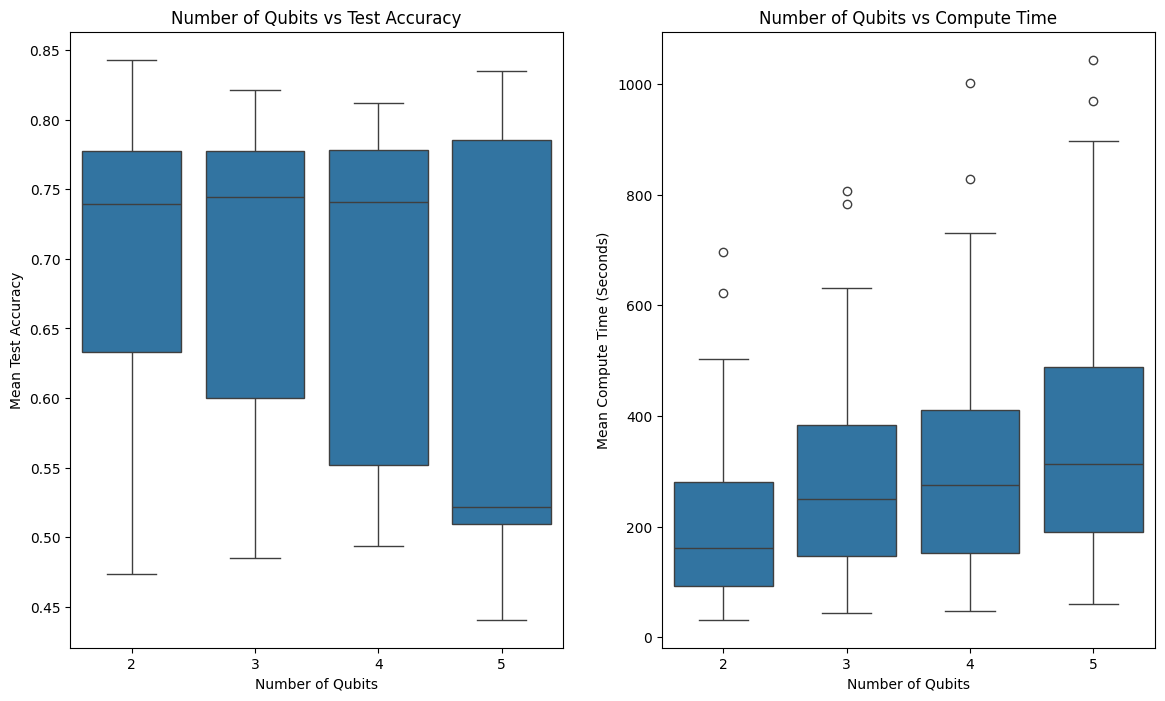

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.boxplot(x="n_qubits", y="test_accuracy_mean", data=df, ax=axes[0])
axes[0].set_title("Number of Qubits vs Test Accuracy")
axes[0].set_xlabel("Number of Qubits")
axes[0].set_ylabel("Mean Test Accuracy")

sns.boxplot(x="n_qubits", y="compute_time_mean", data=df, ax=axes[1])
axes[1].set_title("Number of Qubits vs Compute Time")
axes[1].set_xlabel("Number of Qubits")
axes[1].set_ylabel("Mean Compute Time (Seconds)")

plt.show()

### Scatter Plot of results with Test Accuracy vs Compute Time

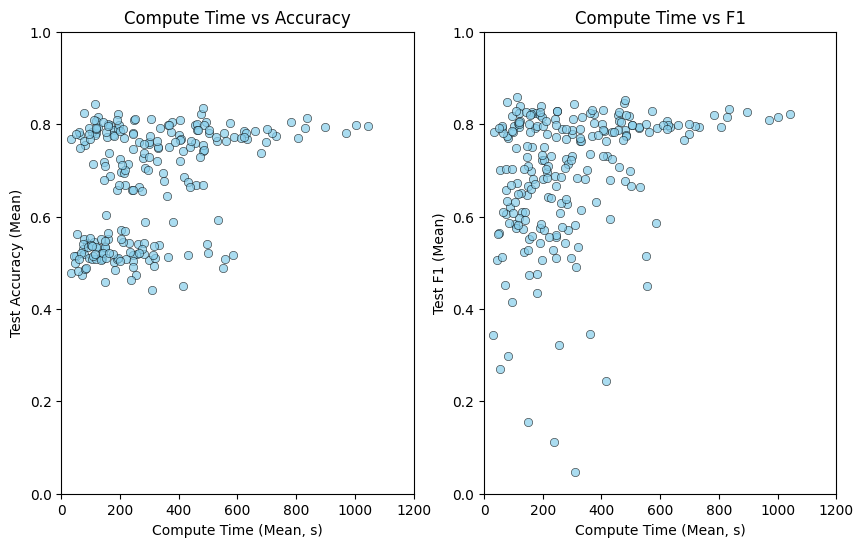

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

sns.scatterplot(x="compute_time_mean", y="test_accuracy_mean", data=df, color="skyblue", edgecolor="black", alpha=0.7, ax=axes[0])
axes[0].set_title("Compute Time vs Accuracy")
axes[0].set_xlabel("Compute Time (Mean, s)")
axes[0].set_ylabel("Test Accuracy (Mean)")

sns.scatterplot(x="compute_time_mean", y="test_f1_mean", data=df, color="skyblue", edgecolor="black", alpha=0.7, ax=axes[1])
axes[1].set_title("Compute Time vs F1")
axes[1].set_xlabel("Compute Time (Mean, s)")
axes[1].set_ylabel("Test F1 (Mean)")

#Set the min and max values of the plots
axes[0].set_xlim(0, 1200)
axes[0].set_ylim(0, 1)
axes[1].set_xlim(0, 1200)
axes[1].set_ylim(0, 1)

plt.show()

### Statistical Significance between test accuracy and each of the circuit "hyper-parameters"

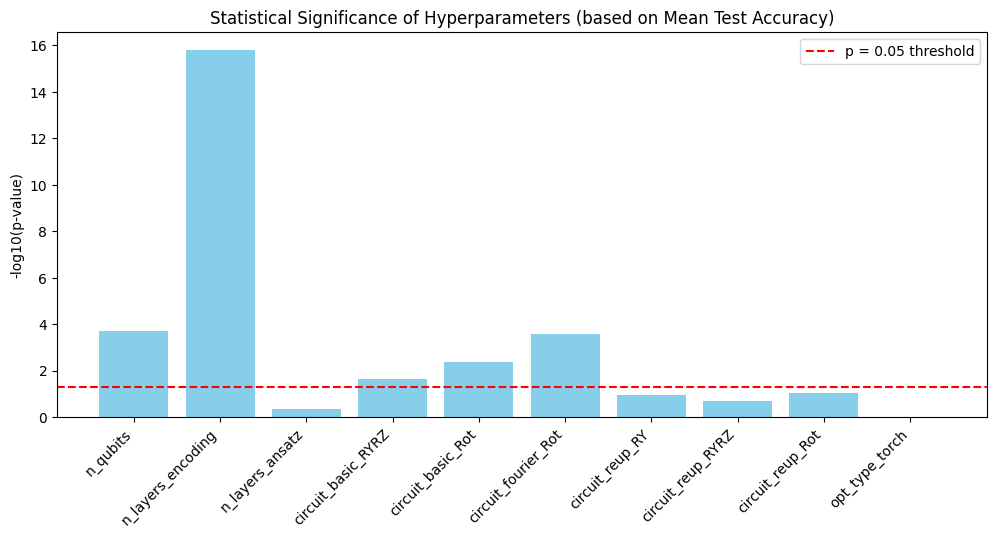

In [55]:
from sklearn.feature_selection import f_regression

#One-hot encode categorical features like circuit and opt_type
categorical_cols = ["circuit", "opt_type", "encoding_type", "ansatz_type"]
continuous_cols = ["n_qubits", "n_layers_encoding", "n_layers_ansatz"]

#Combine all features
X_cat = pd.get_dummies(df[categorical_cols], drop_first=True)
X_cont = df[continuous_cols]
X = pd.concat([X_cont, X_cat], axis=1)
#display(X)
#Target variable (can be test_f1_mean, test_accuracy_mean, etc.)
y = df["test_accuracy_mean"]
f_scores, p_values = f_regression(X, y)

#Convert to -log10(p) for visualization
neg_log_pvals = -np.log10(p_values)
feature_names = X.columns

plt.figure(figsize=(12, 5))
plt.bar(feature_names, neg_log_pvals, color="skyblue")
plt.axhline(-np.log10(0.05), color="red", linestyle="--", label="p = 0.05 threshold")
plt.title("Statistical Significance of Hyperparameters (based on Mean Test Accuracy)")
plt.ylabel("-log10(p-value)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

### Comparing the effect of difference in number of layers of encoding and ansatz against accuracy

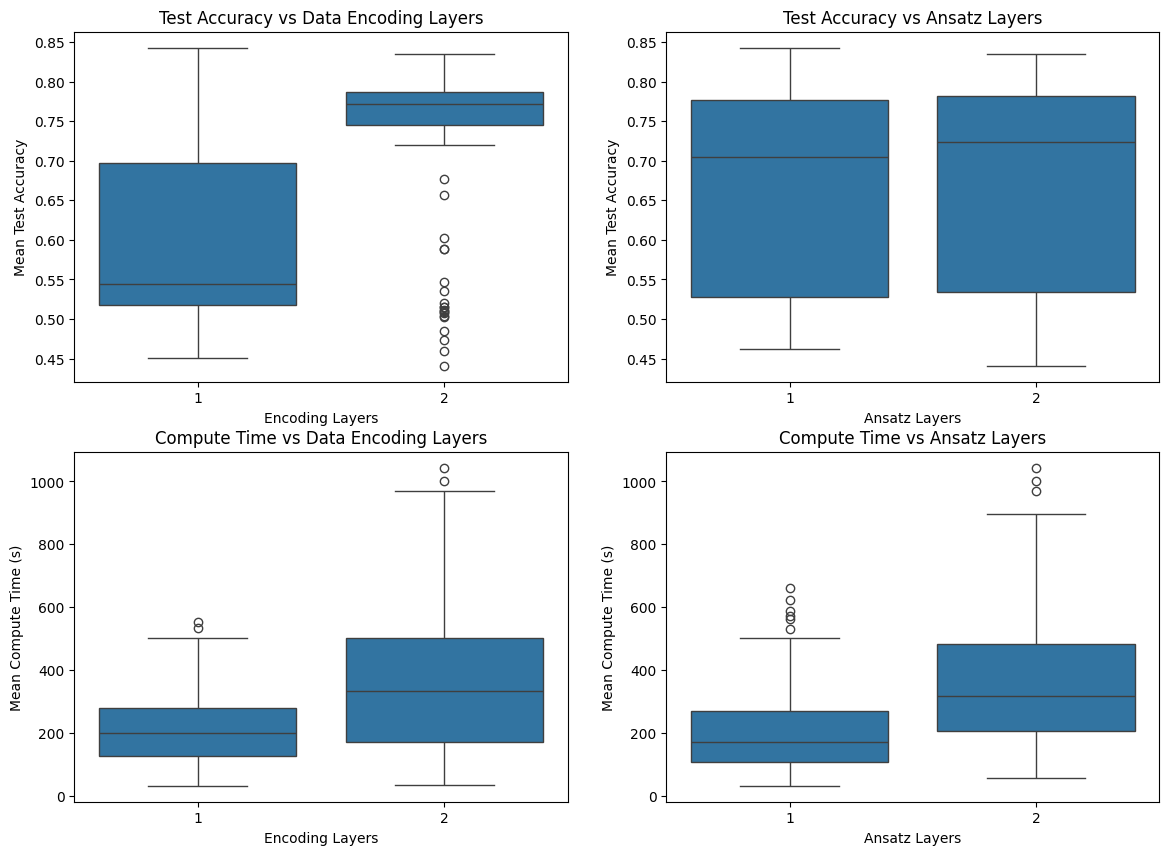

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(x="n_layers_encoding", y="test_accuracy_mean", data=df, ax=axes[0, 0])
axes[0, 0].set_title("Test Accuracy vs Data Encoding Layers")
axes[0, 0].set_xlabel("Encoding Layers")
axes[0, 0].set_ylabel("Mean Test Accuracy")

sns.boxplot(x="n_layers_ansatz", y="test_accuracy_mean", data=df, ax=axes[0, 1])
axes[0, 1].set_title("Test Accuracy vs Ansatz Layers")
axes[0, 1].set_xlabel("Ansatz Layers")
axes[0, 1].set_ylabel("Mean Test Accuracy")

sns.boxplot(x="n_layers_encoding", y="compute_time_mean", data=df, ax=axes[1, 0])
axes[1, 0].set_title("Compute Time vs Data Encoding Layers")
axes[1, 0].set_xlabel("Encoding Layers")
axes[1, 0].set_ylabel("Mean Compute Time (s)")

sns.boxplot(x="n_layers_ansatz", y="compute_time_mean", data=df, ax=axes[1, 1])
axes[1, 1].set_title("Compute Time vs Ansatz Layers")
axes[1, 1].set_xlabel("Ansatz Layers")
axes[1, 1].set_ylabel("Mean Compute Time (s)")

plt.show()

### Circuit comparison with test accuracy and compute time

C:\Users\Eric\AppData\Local\Temp\ipykernel_22864\2256245072.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(agg["circuit"])


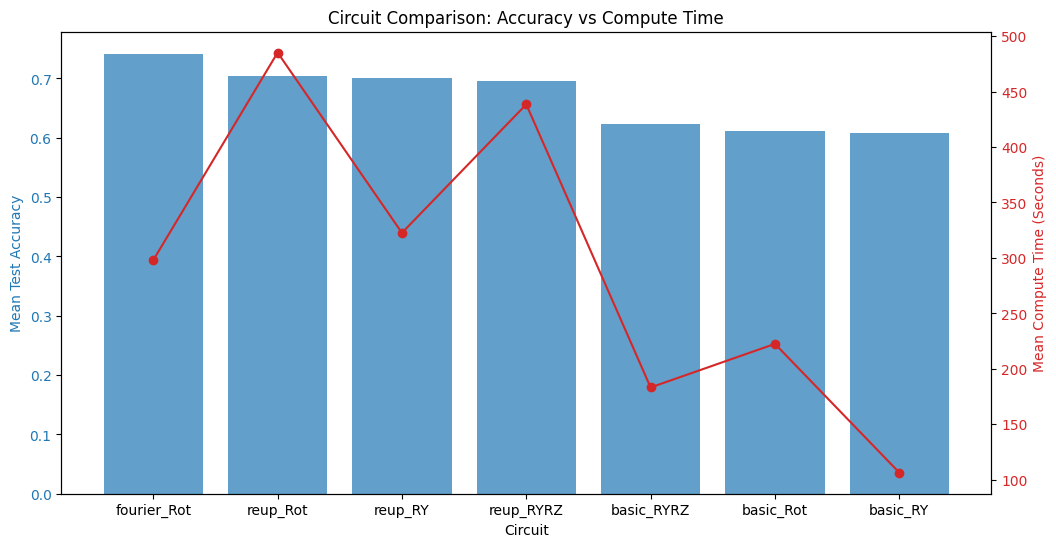

In [57]:
#Aggregate by circuit
agg = df.groupby("circuit")[["test_accuracy_mean", "compute_time_mean"]].mean().reset_index()
agg = agg.sort_values("test_accuracy_mean", ascending=False)#Sort by accuracy


fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = "tab:blue"
ax1.set_xlabel("Circuit")
ax1.set_ylabel("Mean Test Accuracy", color=color1)
ax1.bar(agg["circuit"], agg["test_accuracy_mean"], color=color1, alpha=0.7, label="Accuracy")
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticklabels(agg["circuit"])

#Compute time axis
ax2 = ax1.twinx()
color2 = "tab:red"
ax2.set_ylabel("Mean Compute Time (Seconds)", color=color2)
ax2.plot(agg["circuit"], agg["compute_time_mean"], color=color2, marker="o", label="Compute Time")
ax2.tick_params(axis='y', labelcolor=color2)


plt.title("Circuit Comparison: Accuracy vs Compute Time")
plt.show()

### Encoding and Ansatz Type comparison with Mean Test Accuracy and Compute Time

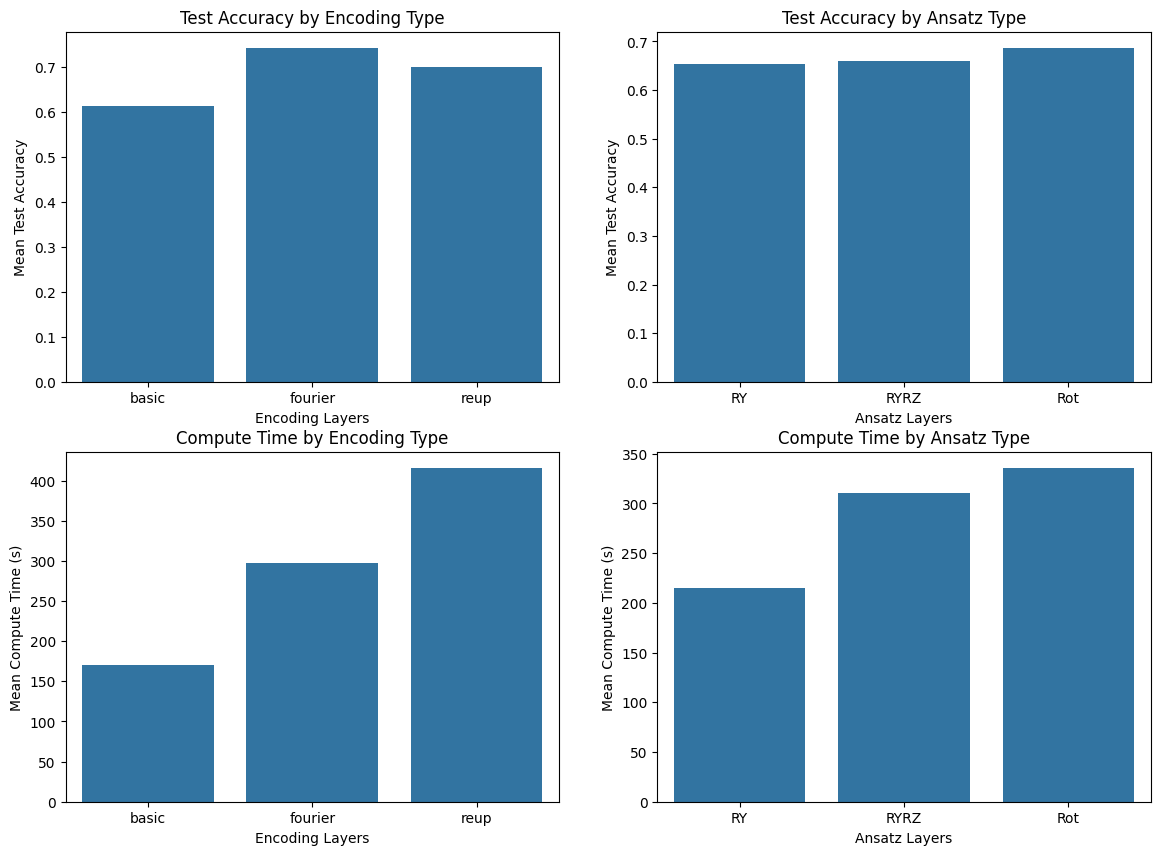

In [58]:
#Group by Encoding and Ansatz Type and calculate the mean of accuracy and compute time
encoding_performance = df.groupby('encoding_type')[['test_accuracy_mean', 'compute_time_mean']].mean()
ansatz_performance = df.groupby('ansatz_type')[['test_accuracy_mean', 'compute_time_mean']].mean()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(x=encoding_performance.index, y='test_accuracy_mean', data=encoding_performance, ax=axes[0, 0])
axes[0, 0].set_title("Test Accuracy by Encoding Type")
axes[0, 0].set_xlabel("Encoding Layers")
axes[0, 0].set_ylabel("Mean Test Accuracy")

sns.barplot(x=ansatz_performance.index, y='test_accuracy_mean', data=ansatz_performance, ax=axes[0, 1])
axes[0, 1].set_title("Test Accuracy by Ansatz Type")
axes[0, 1].set_xlabel("Ansatz Layers")
axes[0, 1].set_ylabel("Mean Test Accuracy")

sns.barplot(x=encoding_performance.index, y='compute_time_mean', data=encoding_performance, ax=axes[1, 0])
axes[1, 0].set_title("Compute Time by Encoding Type")
axes[1, 0].set_xlabel("Encoding Layers")
axes[1, 0].set_ylabel("Mean Compute Time (s)")

sns.barplot(x=ansatz_performance.index, y='compute_time_mean', data=ansatz_performance, ax=axes[1, 1])
axes[1, 1].set_title("Compute Time by Ansatz Type")
axes[1, 1].set_xlabel("Ansatz Layers")
axes[1, 1].set_ylabel("Mean Compute Time (s)")

plt.show()

### Investigating whether it was worth adding pennylane optimiser functionality and incresing grid search from 112 to 224

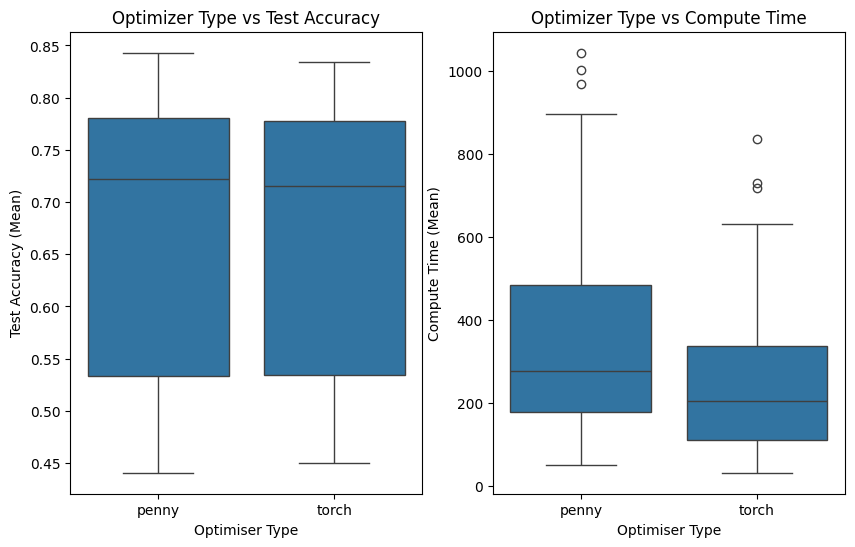

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # 2 rows, 2 columns

sns.boxplot(x="opt_type", y="test_accuracy_mean", data=df, ax=axes[0])
axes[0].set_title("Optimizer Type vs Test Accuracy")
axes[0].set_xlabel("Optimiser Type")
axes[0].set_ylabel("Test Accuracy (Mean)")

sns.boxplot(x="opt_type", y="compute_time_mean", data=df, ax=axes[1])
axes[1].set_title("Optimizer Type vs Compute Time")
axes[1].set_xlabel("Optimiser Type")
axes[1].set_ylabel("Compute Time (Mean)")

plt.show()

# Real Quantum Device

Simulated results show that the best VQC is 2 qubits using fourier_Rot, 2 data encoding layers and 1 ansatz layer.

This is what I will run on the real device

Because of how much time it will take to run the VQC on a real device, I experimented with reducing num_epochs and batch_size.

I found good results with 12 epochs and a batch size of 1-3. Which made my 60 hours of data gathering pointless, as the epochs and batch_size could have been greatly reduced.

In [275]:
your_channel="ibm_quantum"
your_token="300e5bdbd80c998b74a661f6e883ea1f082d5f2608165800c4d27cc36e6868080c0b3073cdc1202ae54182c3fe733adcb7b7401b3565b5e226bc18dc355f74c2"

In [276]:
#Necessary Code to run pennylane as a qiskit device and use ibm backend
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel=your_channel, 
    token=your_token,
    overwrite=True)

from qiskit_ibm_runtime.fake_provider import FakeManilaV2
backend_fake = FakeManilaV2()


service = QiskitRuntimeService()
backend_ibm = service.least_busy(operational=True, simulator=False, min_num_qubits=5)


try:
    NUM_QUBITS_SUPPORTED = 5
    dev = qml.device("qiskit.remote", wires=NUM_QUBITS_SUPPORTED, backend=backend_ibm)
    #dev = qml.device("qiskit.remote", wires=NUM_QUBITS_SUPPORTED, backend=backend_fake)
except Exception as e:
    print(e)

In [277]:
#Redefining required things to run on real machine 
@qml.qnode(dev, diff_method="best")
def fourier_Rot(datapoint, params): 
    """ """
    fourier_state_prep(datapoint)#Apply data encoding
    Rot_ansatz(params)#Apply Ansatz
    return qml.probs(wires=[0])#Measure One Qubit


class CircuitConfig:
    def __init__(self, circuit, num_weights):
        self.circuit = circuit
        self.num_weights= num_weights
        
    def get_num_weights(self, n_qubits, n_layers_encoding, n_layers_ansatz):
        return self.num_weights(n_qubits, n_layers_encoding, n_layers_ansatz)
    
circuits = {"basic_RY": CircuitConfig(basic_RY, lambda q, e, a:   (e * 0) + (a * q * 1)),
            "basic_RYRZ": CircuitConfig(basic_RYRZ, lambda q, e, a: (e * 0) + (a * q * 2)),
            "basic_Rot": CircuitConfig(basic_Rot, lambda q, e, a: (e * 0) + (a * q * 3)),
            #5 for five features
            "reup_RY": CircuitConfig(reup_RY, lambda q, e, a: (e * 5) + (a * q * 1)),
            "reup_RYRZ": CircuitConfig(reup_RYRZ, lambda q, e, a: (e * 5) + (a * q * 2)),
            "reup_Rot": CircuitConfig(reup_Rot, lambda q, e, a: (e * 5) + (a * q * 3)),
            
            "fourier_RY": CircuitConfig(fourier_RY, lambda q, e, a: (e * 0) + (a * q * 1)),
            "fourier_RYRZ": CircuitConfig(fourier_RYRZ, lambda q, e, a: (e * 0) + (a * q * 2)),
            "fourier_Rot": CircuitConfig(fourier_Rot, lambda q, e, a: (e * 0) + (a * q * 3)),
}

Here, I run the fourier_Rot circuit with 2 qubits, 2 encoding layers, 1 ansatz layer, 12 epochs and a batch size of 2 (24 rows) on 10% of the data (118)

This is to leave enough room in test set for inference

{'n_qubits': 2,
 'n_layers_encoding': 2,
 'n_layers_ansatz': 1,
 'shots': 100,
 'n_runs': 1,
 'batch_size': 2,
 'num_epochs': 12,
 'circuit': 'fourier_Rot',
 'opt_type': 'torch'}

Run 1/1: 
Parameter containing:
tensor([2.0725, 4.6212, 0.7795, 1.9931, 6.0780, 5.5769], requires_grad=True)
Circuit Example: 


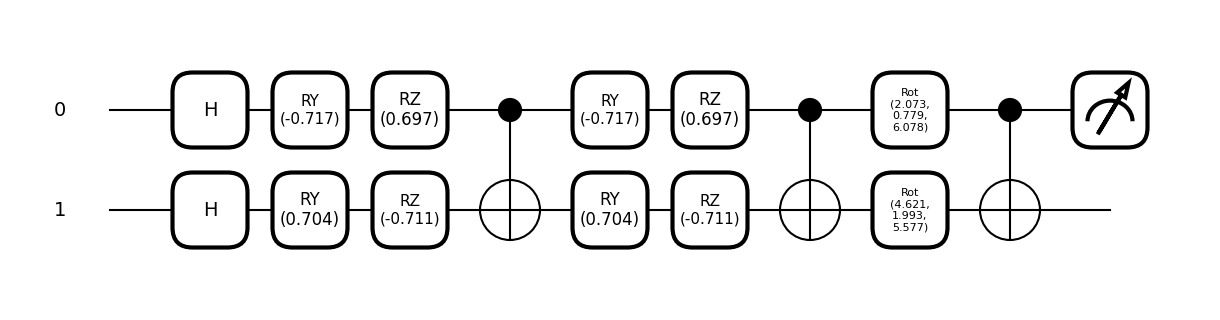

Epoch 1: Loss = 0.19
Epoch 2: Loss = 0.23
Epoch 3: Loss = 0.35
Epoch 4: Loss = 0.37
Epoch 5: Loss = 0.19
Epoch 6: Loss = 0.19


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [264]:
n_qubits = 2
n_layers_encoding = 2
n_layers_ansatz = 1
shots = shots
n_runs = 1
num_epochs = 12
batch_size = 2#int(918*.7)
circuit = circuits["fourier_Rot"].circuit
num_weights = circuits["fourier_Rot"].get_num_weights(n_qubits=n_qubits, n_layers_encoding=n_layers_encoding, n_layers_ansatz=n_layers_ansatz)
opt_type = "torch"

Metrics = EvalMetrics()
Metrics.set_pickle_info(n_qubits, n_layers_encoding, n_layers_ansatz, shots, n_runs, batch_size, num_epochs, circuit, opt_type)
display(Metrics.pickle_info)

for i in range(n_runs):
    print(f"Run {i+1}/{n_runs}: ")
    
    #X and y data
    ["ST_Slope", "ChestPainType", "ExerciseAngina_Y", "OldPeak", "MaxHR"]
    X = data_normalise(row=dataset[["ST_Slope", "ChestPainType"]].to_numpy(), opt_type=opt_type)
    if opt_type == "torch":
        y = torch.tensor(dataset["HeartDisease"].to_numpy())
    else:
        y = qnp.array(dataset["HeartDisease"].to_numpy())
        
        
    #Split Dataset
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size = 0.1, stratify = y)
    
    
    #VQC Initialisation
    vqc = VQC(circuit, num_weights, opt_type=opt_type)
    #Training
    compute_time = vqc.train(X_train, y_train, num_epochs, batch_size)

Run 1/1: 
Circuit Example: 


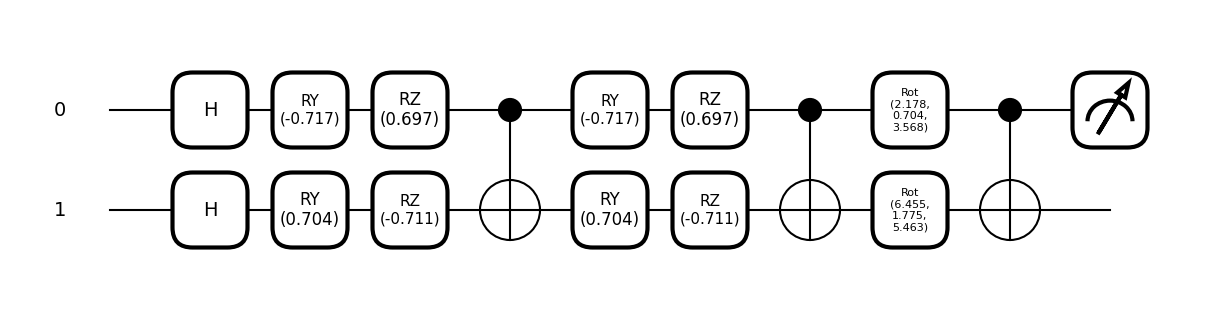

Epoch 1: Loss = 0.31
Epoch 2: Loss = 1.14
Epoch 3: Loss = 1.35
Epoch 4: Loss = 0.33
Epoch 5: Loss = 0.12
Epoch 6: Loss = 0.11
Training Took: 1495.3 Seconds


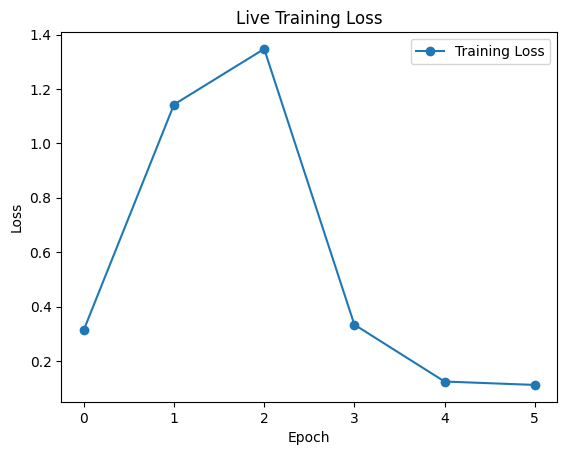

In [265]:
n_qubits = 2
n_layers_encoding = 2
n_layers_ansatz = 1
shots = shots
n_runs = 1
num_epochs = 6
batch_size = 2#int(918*.7)
circuit = circuits["fourier_Rot"].circuit
num_weights = circuits["fourier_Rot"].get_num_weights(n_qubits=n_qubits, n_layers_encoding=n_layers_encoding, n_layers_ansatz=n_layers_ansatz)
opt_type = "torch"

for i in range(n_runs):
    print(f"Run {i+1}/{n_runs}: ")
    #Training
    compute_time = vqc.train(X_train, y_train, num_epochs, batch_size)

In [278]:
#Circuit has to be redefined when switching accounts in ibm
circuit = circuits["fourier_Rot"].circuit
num_weights = circuits["fourier_Rot"].get_num_weights(n_qubits=n_qubits, n_layers_encoding=n_layers_encoding, n_layers_ansatz=n_layers_ansatz)

saved_weights = vqc.weights
test_vqc = VQC(circuit, num_weights, opt_type=opt_type)
test_vqc.weights = saved_weights

Parameter containing:
tensor([0.5149, 0.5804, 2.1935, 2.9441, 5.6950, 4.9833], requires_grad=True)


Sampling a subset of test set to run inference through real device. (Took 5 accounts and many hours to sit and wait in queue for 100 rows, then 200 rows)

In [ ]:
n_samples = X_test.shape[0]
n_subset = 200#n_samples // 10

#Generate random indices for 1/8th of the dataset
indices = torch.randperm(n_samples)[:n_subset]

#Subset X_test and y_test using those indices
X_subset = X_test[indices]
y_subset = y_test[indices]

y_test_pred_proba_200 = test_vqc.predict_proba(X_subset).detach().numpy()


Averaged Performance Metrics Over 1 Runs:
Train Accuracy: 0.5000 ± 0.0000				 Test Accuracy: 0.7400 ± 0.0000
Train Precision: 0.0000 ± 0.0000			 Test Precision: 0.7115 ± 0.0000
Train Recall: 0.0000 ± 0.0000				 Test Recall: 0.7708 ± 0.0000
Train F1-score: 0.0000 ± 0.0000				 Test F1-score: 0.7400 ± 0.0000
Train ROC AUC: 0.5000 ± 0.0000				 Test ROC AUC: 0.7843 ± 0.0000
Train Precision-Recall AUC: 0.5000 ± 0.0000		 Test Precision-Recall AUC: 0.7881 ± 0.0000
Train Log Loss: 18.0218 ± 0.0000				 Test Log Loss: 0.5870 ± 0.0000
Compute Time: 1495.2759 ± 0.0000


C:\Users\Eric\anaconda3\envs\notebook\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


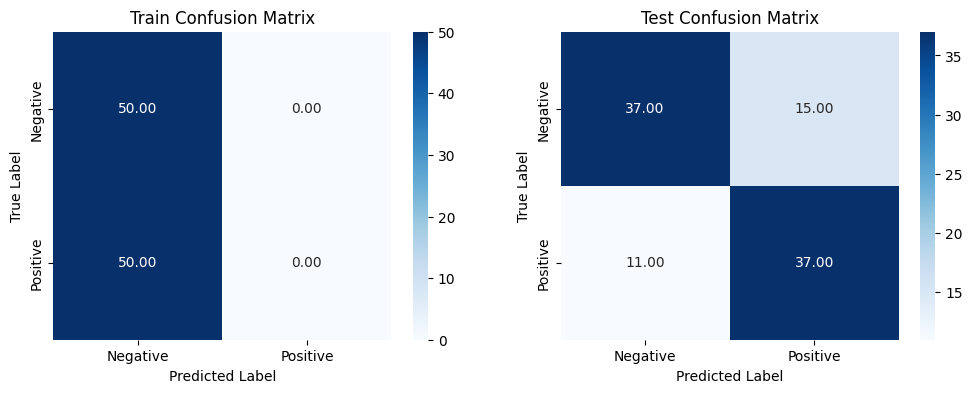

In [287]:
#Testing and storing data
y_test_pred_200 = (y_test_pred_proba_200 > 0.5)

Metrics.add_predictions([1,0], [0,0], [0,0], y_subset.numpy(), y_test_pred_200, y_test_pred_proba_200, compute_time)
Metrics.print_metrics()

with open(f'Extra Pickles/200Rows_REALQUANTUM_{Metrics.pickle_info["circuit"]}_{Metrics.pickle_info["n_qubits"]}Qubit_{Metrics.pickle_info["n_layers_encoding"]}Encode_{Metrics.pickle_info["n_layers_ansatz"]}Ansatz_{Metrics.pickle_info["opt_type"]}OptType.pkl', 'wb') as f:  # open a text file
    pickle.dump(Metrics, f) # serialize the list
f.close()


Averaged Performance Metrics Over 1 Runs:
Train Accuracy: 0.5000 ± 0.0000				 Test Accuracy: 0.7400 ± 0.0000
Train Precision: 0.0000 ± 0.0000			 Test Precision: 0.7115 ± 0.0000
Train Recall: 0.0000 ± 0.0000				 Test Recall: 0.7708 ± 0.0000
Train F1-score: 0.0000 ± 0.0000				 Test F1-score: 0.7400 ± 0.0000
Train ROC AUC: 0.5000 ± 0.0000				 Test ROC AUC: 0.7843 ± 0.0000
Train Precision-Recall AUC: 0.5000 ± 0.0000		 Test Precision-Recall AUC: 0.7881 ± 0.0000
Train Log Loss: 18.0218 ± 0.0000				 Test Log Loss: 0.5870 ± 0.0000
Compute Time: 1495.2759 ± 0.0000


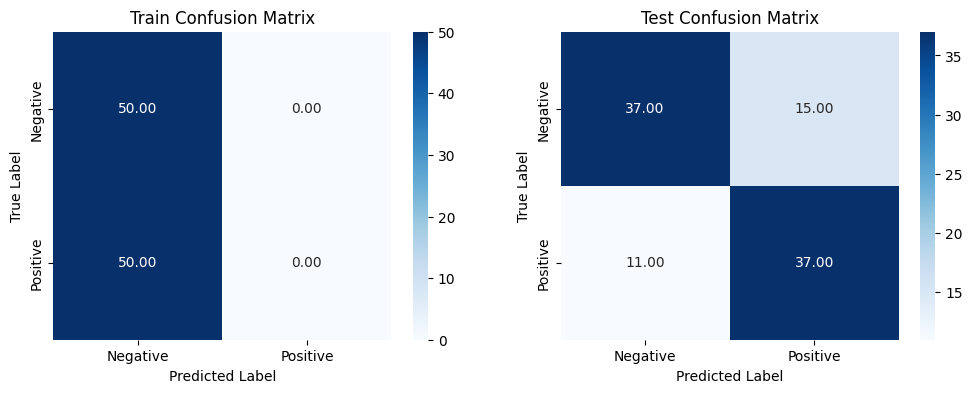

In [288]:
file_path = "Extra Pickles/100Rows_REALQUANTUM_fourier_Rot_2Qubit_2Encode_1Ansatz_torchOptType.pkl"
with open(file_path, 'rb') as f:
    metrics = pickle.load(f)
metrics.print_metrics()

In [ ]:
file_path = "Extra Pickles/200Rows_REALQUANTUM_fourier_Rot_2Qubit_2Encode_1Ansatz_torchOptType.pkl"
with open(file_path, 'rb') as f:
    metrics = pickle.load(f)
metrics.print_metrics()

# Future Work

There is plenty of work that could still be done here

<ul>
    <li>More exploration and experimentation with circuit design</li>
    <li>Experimentation around the fourier_Rot circuit such as different ansatz, effect of reuploading etc.</li>
    <li>More data encoding strategies, such adding more features with PCA or otherwise</li>
</ul>

# Conclusion

Classical machine learning is undeniably better than Quantum machine learning regarding classification in all metrics of performance, training time and cost.

The Variational Quantum Classifier that I implemented was not only signifigantly slower and more difficult to run, it also performed slightly worse than the baseline of 85%.